# DATA201 - Project 2

Please use this page http://apps.ecs.vuw.ac.nz/submit/DATA201 for submitssion and submit only this single Jupyter notebook with your code added into it at the appropriate places.

The due date is **Friday 7th June, before midnight**.

The dataset for this assignment are files **loan_train.csv** and **loan_test.csv** which are provided with this notebook.

Please choose menu items *Kernel => Restart & Run All* then *File => Save and Checkpoint* in Jupyter before submission.

## Problem Statement

A company deals in all home loans. They have presence across all urban, semi urban and rural areas.
Customers first apply for home loan after that company validates the customer eligibility for loan.

The company wants to automate the loan eligibility process (in real-time) based on customer detail provided while filling online application form. These details are Gender, Marital Status, Education, Number of Dependents, Income, Loan Amount, Credit History and others. To automate this process, they have given a problem to identify the customers segments, those are eligible for loan amount so that they can specifically target these customers.

## Data

| Variable	            | Description                                     |
|-----------------------|-------------------------------------------------|
|``Loan_ID``            |Unique Loan ID                                   |
|``Gender``             |Male / Female                                    |
|``Married``            |Applicant married (Y/N)                          |
|``Dependents``         |Number of dependents                             |
|``Education``          |Applicant Education (Graduate / Under Graduate)  |
|``Self_Employed``      |Self employed (Y/N)                              |
|``ApplicantIncome``    |Applicant income                                 |
|``CoapplicantIncome``  |Coapplicant income                               |
|``LoanAmount``         |Loan amount in thousands                         |
|``Loan_Amount_Term``   |Term of loan in months                           |
|``Credit_History``     |Credit history meets guidelines                  |
|``Property_Area``      |Urban / Semi Urban / Rural                       |
|``Loan_Status``        |Loan approved (Y/N)                              |

Use ``loan_train.csv`` to build a model to predict if a loan application is approved (``Loan_Status`` is the label), and test the model using ``loan_test.csv``. 

## Model Evaluation

Use AUC (area under the receiver operating characteristic curve) as the evaluation metric.

## Guidelines

- This is an End-to-End machine learning project. Please review lecture notes in weeks 6 and 7 carefully before starting the project.
- This is also an *open* project. There is no restriction in using any algorithms or packages, even those which are not discussed in the lectures.
- The followings are expected in this project (**maximum possible points: 15++**):
    + Exploratory analysis and visualisation [**2 points**]
    + Data preparation (outliers and missing values treatment, feature selection, feature engineering, feature scaling, etc. - not all of those steps are required) [**3 points**]
    + Model training (train many quick models, measure and compare their performance, analyze important features and types of errors, ... then short-list the top 3 to 5 most promising models, preferring models that make different types of errors) [**4 points**]
    + Model tuning (fine-tune the hyper-parameters using cross-validation, try ensemble methods, ... then measure the final model's performance on the test set) [**5 points**]
    + Present your solution (present interesting points you noticed along the way (what worked and what did not, your assumptions and your systems limitations), communicate your key findings through beautiful visualizations or easy-to-remember statements, etc.) [**1 point**]
- Bonus points (maximum **2 points**): for those who obtain the highest AUC value on the test set and for those who automate the steps above as much as possible.

In [15]:
import numpy               as np
import pandas              as pd
import matplotlib          as mpl
import matplotlib.pyplot   as plt
from pandas.plotting       import scatter_matrix
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline      import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model  import LinearRegression
from sklearn.tree          import DecisionTreeRegressor
from datetime              import datetime
from time                          import time, localtime, strftime
from sklearn.model_selection       import GridSearchCV, RandomizedSearchCV, train_test_split, cross_val_score, cross_val_predict
from sklearn.metrics               import mean_squared_error, r2_score, mean_absolute_error, confusion_matrix, classification_report, precision_recall_curve, roc_curve
from sklearn.metrics               import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.preprocessing         import StandardScaler
from sklearn.neighbors             import KNeighborsClassifier
from sklearn.naive_bayes           import GaussianNB
from sklearn.svm                   import SVC
from sklearn.tree                  import DecisionTreeClassifier
from sklearn.ensemble              import BaggingClassifier, VotingClassifier, RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neural_network        import MLPClassifier
from sklearn.linear_model          import LogisticRegression
import warnings
warnings.filterwarnings('ignore')
import random

%matplotlib inline

In [16]:
seed = 42                                                                
random.seed(seed)                      
np.random.seed(seed)  

### Data Loading

Load the training data set and test data set from .csv files as two DataFrames.

In [17]:
df_train = pd.read_csv('loan_train.csv')
df_test  = pd.read_csv('loan_test.csv')

# 1. Exploratory Data Analysis

Take a look at the top 3 rows of training set and test set.

In [18]:
df_train.head(3)

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001535,Male,No,0,Graduate,No,3254,0.0,50.0,360.0,1.0,Urban,Y
1,LP001792,Male,Yes,1,Graduate,No,3315,0.0,96.0,360.0,1.0,Semiurban,Y
2,LP002443,Male,Yes,2,Graduate,No,3340,1710.0,150.0,360.0,0.0,Rural,N


In [19]:
df_test.head(3)

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001528,Male,No,0,Graduate,No,6277,0.0,118.0,360.0,0.0,Rural,N
1,LP002804,Female,Yes,0,Graduate,No,4180,2306.0,182.0,360.0,1.0,Semiurban,Y
2,LP002945,Male,Yes,0,Graduate,Yes,9963,0.0,180.0,360.0,1.0,Rural,Y


#### Data Sets Dimension Check

In [20]:
print("There are " + str(df_train.shape[0]) + " rows and " + str(df_train.shape[1]) + " columns of data in train set;")
print("There are " + str(df_test.shape[0])  + " rows and " + str(df_test.shape[1])  + " columns of data in test set;")
print("Train set takes %.2f%%, test set takes %.2f%%." 
      % (df_train.shape[0] / (df_train.shape[0] + df_test.shape[0]) * 100,
         df_test.shape[0]  / (df_train.shape[0] + df_test.shape[0]) * 100))

There are 491 rows and 13 columns of data in train set;
There are 123 rows and 13 columns of data in test set;
Train set takes 79.97%, test set takes 20.03%.


#### Attributes & Missing Data Check

In [21]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 491 entries, 0 to 490
Data columns (total 13 columns):
Loan_ID              491 non-null object
Gender               480 non-null object
Married              488 non-null object
Dependents           483 non-null object
Education            491 non-null object
Self_Employed        464 non-null object
ApplicantIncome      491 non-null int64
CoapplicantIncome    491 non-null float64
LoanAmount           471 non-null float64
Loan_Amount_Term     479 non-null float64
Credit_History       448 non-null float64
Property_Area        491 non-null object
Loan_Status          491 non-null object
dtypes: float64(4), int64(1), object(8)
memory usage: 49.9+ KB


In [22]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123 entries, 0 to 122
Data columns (total 13 columns):
Loan_ID              123 non-null object
Gender               121 non-null object
Married              123 non-null object
Dependents           116 non-null object
Education            123 non-null object
Self_Employed        118 non-null object
ApplicantIncome      123 non-null int64
CoapplicantIncome    123 non-null float64
LoanAmount           121 non-null float64
Loan_Amount_Term     121 non-null float64
Credit_History       116 non-null float64
Property_Area        123 non-null object
Loan_Status          123 non-null object
dtypes: float64(4), int64(1), object(8)
memory usage: 12.6+ KB


In [23]:
print("There are 491 instances in train set, 123 instances in test set.")
print("Missing data are found in 7 out of 13 features in train set, 6 out 13 features in test set.")
print("Apart from 5 numerical features, the dtype of 8 features are object.")
print("After looking through the data sets, they should be categorical attributes.")

There are 491 instances in train set, 123 instances in test set.
Missing data are found in 7 out of 13 features in train set, 6 out 13 features in test set.
Apart from 5 numerical features, the dtype of 8 features are object.
After looking through the data sets, they should be categorical attributes.


#### Categorical Attributes Exploration

Printing the values and counts of categorical attributes in both train and test sets:

In [24]:
print("1. Gender in Train Set & Test Set")
print(df_train["Gender"].value_counts())
print(df_test["Gender"].value_counts())
print("==========")
print("2. Married in Train Set & Test Set")
print(df_train["Married"].value_counts())
print(df_test["Married"].value_counts())
print("==========")
print("3. Dependents in Train Set & Test Set")
print(df_train["Dependents"].value_counts())
print(df_test["Dependents"].value_counts())
print("==========")
print("4. Education in Train Set & Test Set")
print(df_train["Education"].value_counts())
print(df_test["Education"].value_counts())
print("==========")
print("5. Self_Employed in Train Set & Test Set")
print(df_train["Self_Employed"].value_counts())
print(df_test["Self_Employed"].value_counts())
print("==========")
print("6. Property_Area in Train Set & Test Set")
print(df_train["Property_Area"].value_counts())
print(df_test["Property_Area"].value_counts())
print("==========")
print("7. Loan_Status in Train Set & Test Set")
print(df_train["Loan_Status"].value_counts())
print(df_test["Loan_Status"].value_counts())

1. Gender in Train Set & Test Set
Male      393
Female     87
Name: Gender, dtype: int64
Male      96
Female    25
Name: Gender, dtype: int64
2. Married in Train Set & Test Set
Yes    319
No     169
Name: Married, dtype: int64
Yes    79
No     44
Name: Married, dtype: int64
3. Dependents in Train Set & Test Set
0     276
1      85
2      83
3+     39
Name: Dependents, dtype: int64
0     69
2     18
1     17
3+    12
Name: Dependents, dtype: int64
4. Education in Train Set & Test Set
Graduate        380
Not Graduate    111
Name: Education, dtype: int64
Graduate        100
Not Graduate     23
Name: Education, dtype: int64
5. Self_Employed in Train Set & Test Set
No     398
Yes     66
Name: Self_Employed, dtype: int64
No     102
Yes     16
Name: Self_Employed, dtype: int64
6. Property_Area in Train Set & Test Set
Semiurban    184
Urban        162
Rural        145
Name: Property_Area, dtype: int64
Semiurban    49
Urban        40
Rural        34
Name: Property_Area, dtype: int64
7. Loan_Sta

#### Numerical Attributes Exploration

In [25]:
df_train.describe()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History
count,491.000000,491.000000,471.000000,479.000000,448.000000
mean,5529.997963,1569.537271,147.309979,341.286013,0.850446
std,6457.784318,2789.523475,87.096507,65.855043,0.357032
min,210.000000,0.000000,9.000000,12.000000,0.000000
25%,2906.000000,0.000000,100.000000,360.000000,1.000000
50%,3859.000000,1032.000000,128.000000,360.000000,1.000000
75%,5825.000000,2241.000000,168.000000,360.000000,1.000000
max,81000.000000,41667.000000,700.000000,480.000000,1.000000


In [26]:
df_test.describe()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History
count,123.000000,123.000000,121.000000,121.000000,116.000000
mean,4898.333333,1827.659512,142.917355,344.826446,0.810345
std,4438.739824,3423.180578,79.687053,62.310871,0.393729
min,150.000000,0.000000,25.000000,84.000000,0.000000
25%,2649.000000,0.000000,100.000000,360.000000,1.000000
50%,3620.000000,1483.000000,123.000000,360.000000,1.000000
75%,5509.500000,2479.000000,164.000000,360.000000,1.000000
max,39147.000000,33837.000000,500.000000,480.000000,1.000000


# 2. Visualisation

Two helper functions are defined for visualisation, to convert the categorical attributes into numerical for plotting.

In [27]:
def dependents_to_num(value):
    if   value == '0':  return 0
    elif value == '1':  return 1
    elif value == '2':  return 2
    elif value == '3+': return 3

In [28]:
# larger number can be interpreted as more urbanised area the applicants live in
def property_area_to_num(value):
    if   value == 'Rural':      return 0
    elif value == 'Semiurban':  return 1
    elif value == 'Urban':      return 2

#### Visualisation of Training Set

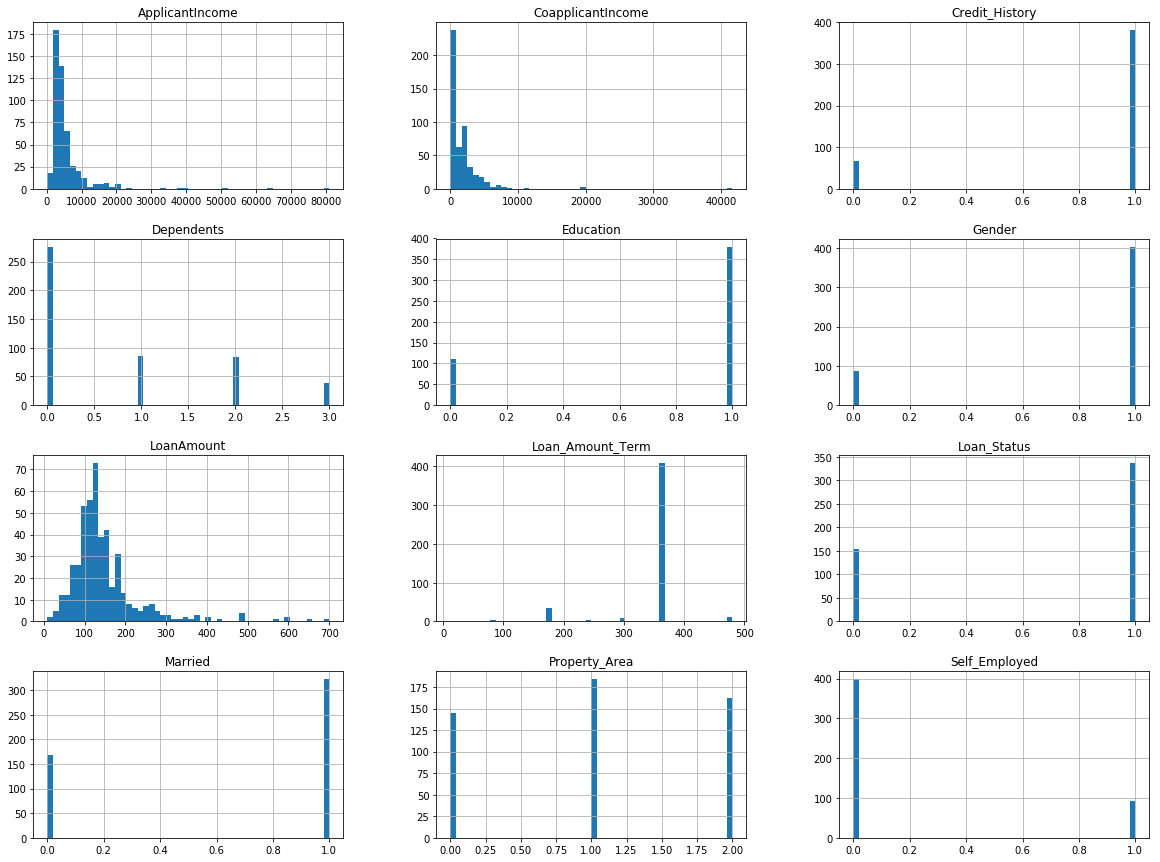

In [29]:
# The categorical attributes are converted into numercical types for visualisation purpose, and may be useful
# in a later stage.
df_train_num = df_train.copy()
df_train_num["Gender"]        = df_train_num.Gender.apply(lambda x:        0 if x == "Female"       else 1)
df_train_num["Married"]       = df_train_num.Married.apply(lambda x:       0 if x == "No"           else 1)
df_train_num["Dependents"]    = df_train_num.Dependents.apply(lambda x:    dependents_to_num(x))
df_train_num["Education"]     = df_train_num.Education.apply(lambda x:     0 if x == "Not Graduate" else 1)
df_train_num["Self_Employed"] = df_train_num.Self_Employed.apply(lambda x: 0 if x == "No"           else 1)
df_train_num["Property_Area"] = df_train_num.Property_Area.apply(lambda x: property_area_to_num(x))
df_train_num["Loan_Status"]   = df_train_num.Loan_Status.apply(lambda x:   0 if x == "N"            else 1)
df_train_num.hist(bins = 50, figsize = (20, 15), layout = (4, 3));

We can find some outliers in the distributions of Applicant Income & Co-applicant Income, which will be handled later on. We also find that there are about 340 cases are approved, but 150 disapproved, which means this is an imbalance data set. So if getting relatively high accuracy later on, more attention needs to be taken, such as checking more indices like performance matrix.

#### Visualisation of Test Set

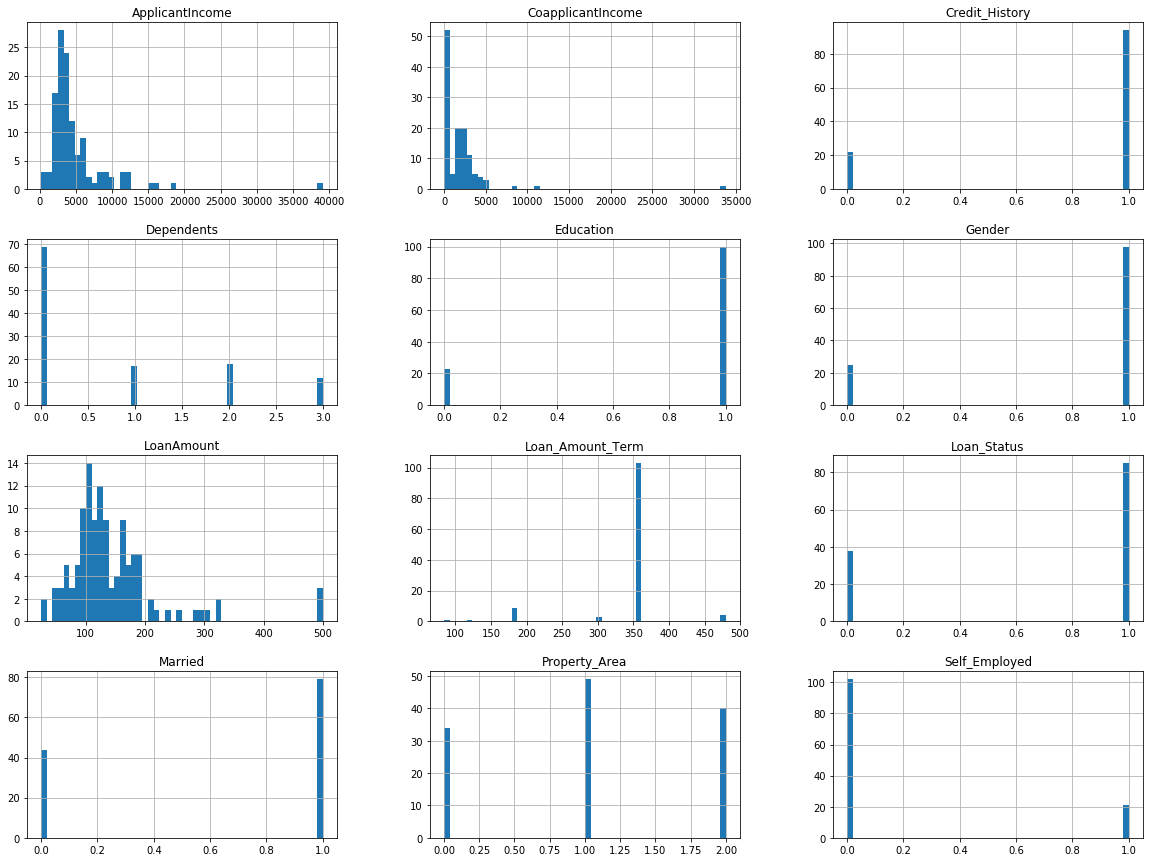

In [30]:
df_test_num = df_test.copy()
df_test_num["Gender"]        = df_test_num.Gender.apply(lambda x:        0 if x == "Female"       else 1)
df_test_num["Married"]       = df_test_num.Married.apply(lambda x:       0 if x == "No"           else 1)
df_test_num["Dependents"]    = df_test_num.Dependents.apply(lambda x:    dependents_to_num(x))
df_test_num["Education"]     = df_test_num.Education.apply(lambda x:     0 if x == "Not Graduate" else 1)
df_test_num["Self_Employed"] = df_test_num.Self_Employed.apply(lambda x: 0 if x == "No"           else 1)
df_test_num["Property_Area"] = df_test_num.Property_Area.apply(lambda x: property_area_to_num(x))
df_test_num["Loan_Status"]   = df_test_num.Loan_Status.apply(lambda x:   0 if x == "N"            else 1)
df_test_num.hist(bins = 50, figsize = (20, 15), layout = (4, 3));

In [31]:
print("The categorical attributes are converted into numercical types for visualisation purpose, and may be useful")
print("in a later stage.")
print("Feathure scaling should be considered due to the very different scales among attributes and the havey tails")
print("in several histograms.")

The categorical attributes are converted into numercical types for visualisation purpose, and may be useful
in a later stage.
Feathure scaling should be considered due to the very different scales among attributes and the havey tails
in several histograms.


#### Initial Correlations Check (numerical)

Correlations between the attribute to be predicted and all the other attributes are checked after converting all the object type attributes into numerical type.  
Credit History is found most related to the loan approval result in both training set and test set (both >0.5).

In [32]:
correlation_matrix_train = df_train_num.corr()
correlation_matrix_train["Loan_Status"].sort_values(ascending = False)

Loan_Status          1.000000
Credit_History       0.537914
Education            0.085899
Married              0.064618
Property_Area        0.035185
Dependents           0.025777
Loan_Amount_Term     0.025708
LoanAmount          -0.006558
Self_Employed       -0.009309
Gender              -0.014798
ApplicantIncome     -0.015775
CoapplicantIncome   -0.047198
Name: Loan_Status, dtype: float64

In [33]:
correlation_matrix_test = df_test_num.corr()
correlation_matrix_test["Loan_Status"].sort_values(ascending = False)

Loan_Status          1.000000
Credit_History       0.646258
Married              0.198463
Gender               0.143259
Education            0.085485
Self_Employed        0.069573
ApplicantIncome      0.060873
Property_Area        0.019404
Dependents          -0.070366
CoapplicantIncome   -0.100207
LoanAmount          -0.169022
Loan_Amount_Term    -0.217106
Name: Loan_Status, dtype: float64

#### Correlations Check (1-Hot)

There is another way to deal with the categorical data, which is using 1-hot. The correlations between Loan Status and all other attributes after 1-hot conversion are also checked.  
Correlations check for 1-hot is in section 3.3.2

# 3. Data Preparation

### 3.1 Missing Data Handling

In [34]:
print("There are " + str(len(df_train[df_train.isnull().any(axis = 1)])) + " out of " + str(len(df_train)) + " instances in training set with missing data.")
print("There are " + str(len(df_test[df_test.isnull().any(axis = 1)]))   + " out of " + str(len(df_test))  + " instances in test set with missing data.")
print("Although most of the attributes (except for Loan_ID) contain important information in deciding whether the application")
print("can be approved, and most of the attributes are binary or categorical, filling with mean or zero may not be good, but since");
print("there are only hundreds of instences in the whole data set, the missing data will be filled by mode or average, rather than")
print("just removed.")

There are 110 out of 491 instances in training set with missing data.
There are 24 out of 123 instances in test set with missing data.
Although most of the attributes (except for Loan_ID) contain important information in deciding whether the application
can be approved, and most of the attributes are binary or categorical, filling with mean or zero may not be good, but since
there are only hundreds of instences in the whole data set, the missing data will be filled by mode or average, rather than
just removed.


#### 3.1.1 Drop Instances with Missing Data (deprecated)

After comparing with 3.1.2 by filling missing data with mode value or each column in the data set, this dropping strategy has been abandoned, due to the lower training performance than 3.1.2.

In [35]:
#df_train = df_train.dropna()
#df_test  = df_test.dropna()
#df_train = df_train.reset_index(drop = True)
#df_test  = df_test.reset_index(drop = True)
#print("There are " + str(len(df_train)) + " instances left in train set after removing missing-data instances;")
#print("There are " + str(len(df_test))  + " instances left in test set after removing missing-data instances.")

#### 3.1.2 Fill Missing Data

The instances with missing data was initially dropped (about 1/5 of the original data set). But, considering this is relatively small data set, and too many missing data. The missing values are filled, either by mode (categorical) or average(numerical).

In [36]:
# calculate the mean value across the original dataset
LoanAmount_mean = (df_train.LoanAmount.mean() * df_train.LoanAmount.count() + df_test.LoanAmount.mean() * df_test.LoanAmount.count()) / (df_train.LoanAmount.count() + df_test.LoanAmount.count())

In [37]:
def fill_missing_data(df):
    # Replace missing values
    df['Self_Employed'   ].fillna('No', inplace = True)                             # 398N 66Y (train) 102N 16Y(test)
    df['LoanAmount'      ].fillna(LoanAmount_mean,                  inplace = True)
    df['Gender'          ].fillna(df['Gender'          ].mode()[0], inplace = True) # 393M 87F & 96M 25F
    df['Married'         ].fillna(df['Married'         ].mode()[0], inplace = True) # 319Y 169N & 79Y 44N
    df['Dependents'      ].fillna(df['Dependents'      ].mode()[0], inplace = True) # 276(0) & 69(0)
    df['Loan_Amount_Term'].fillna(df['Loan_Amount_Term'].mode()[0], inplace = True) 
    df['Credit_History'  ].fillna(df['Credit_History'  ].mode()[0], inplace = True)

fill_missing_data(df_train)
fill_missing_data(df_test)

### 3.2 Outliers Handling

One instance is removed in this section due to much out-of-range of its Applicant Income. It may affect the results of some modelling which are sensitive to outliers.

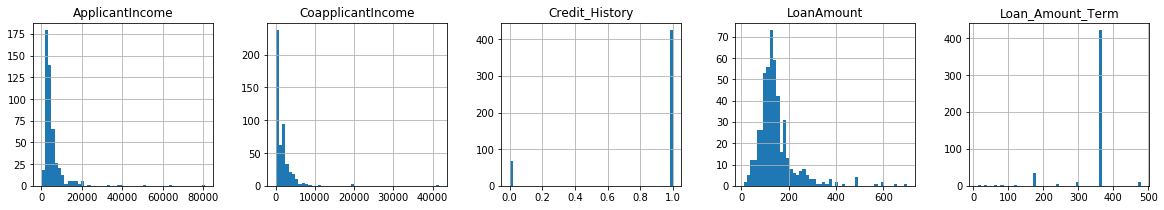

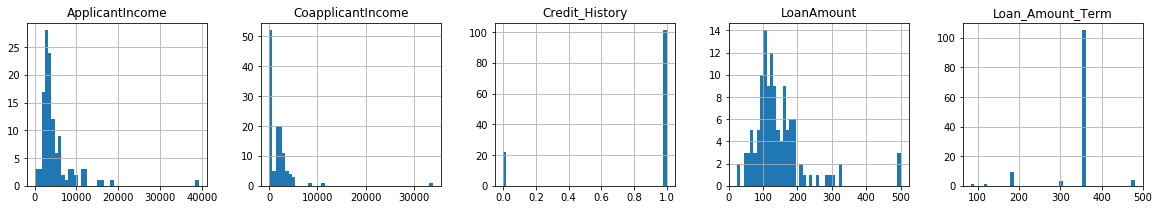

In [38]:
df_train.hist(bins = 50, figsize = (20, 3), layout = (1, 5));
df_test.hist(bins = 50,  figsize = (20, 3), layout = (1, 5));

In [39]:
print("There are several outliers in Applicant_Income and Coapplicant_Income in both train and test set,")
print("especially the instance with Applicant_Income of 80,000 in training set, which is much larger than the")
print("largest Applicant_Income in test set, which could be considered to remove.")

There are several outliers in Applicant_Income and Coapplicant_Income in both train and test set,
especially the instance with Applicant_Income of 80,000 in training set, which is much larger than the
largest Applicant_Income in test set, which could be considered to remove.


In [40]:
df_train[df_train.ApplicantIncome > 80000]

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
119,LP002317,Male,Yes,3+,Graduate,No,81000,0.0,360.0,360.0,0.0,Rural,N


In [41]:
print("Ths CoapplicantIncome of this instance is 0, so the total family income is 81,000.")
print("Looking into the test set, there are also 2 outliers in ApplicantIncome and CoapplicantIncome, and the sum of the")
print("two incomes are comparable to 81,000. So, we'd better confirm whether the 2 outliers in test set come from the same")
print("family.")

Ths CoapplicantIncome of this instance is 0, so the total family income is 81,000.
Looking into the test set, there are also 2 outliers in ApplicantIncome and CoapplicantIncome, and the sum of the
two incomes are comparable to 81,000. So, we'd better confirm whether the 2 outliers in test set come from the same
family.


In [42]:
df_test[df_test.ApplicantIncome > 30000]

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
27,LP001640,Male,Yes,0,Graduate,Yes,39147,4750.0,120.0,360.0,1.0,Semiurban,Y


In [43]:
df_test[df_test.CoapplicantIncome > 30000]

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
22,LP002893,Male,No,0,Graduate,No,1836,33837.0,90.0,360.0,1.0,Urban,N


In [44]:
print("However, they are not from same family. So, the outlier in train set can be removed.")

However, they are not from same family. So, the outlier in train set can be removed.


In [45]:
df_train = df_train[df_train.ApplicantIncome < 80000]
df_train = df_train.reset_index(drop = True)
print("There are " + str(len(df_train)) + " instances left in train set after removing outlier.")

There are 490 instances left in train set after removing outlier.


### 3.3 Categorical Attributes Handling

There are 2 ways of handling the categorical attributes: one is to represent the information using number, such as using number 0 to represent "No", "Not Graduate", "N", "Female", "Rural", and number 1 to represent "Yes", "Graduate", "Y", "Male", "Urban", 0.5 to represent "Semiurban" (the attribute can be interpreted as urbanisation); the other way is to use 1-hot encoder.

#### 3.3.1 Categotical to Numeric

In [46]:
df_train_num = df_train.copy()
df_train_num["Gender"]        = df_train_num.Gender.apply(lambda x:        0 if x == "Female"       else 1)
df_train_num["Married"]       = df_train_num.Married.apply(lambda x:       0 if x == "No"           else 1)
df_train_num["Dependents"]    = df_train_num.Dependents.apply(lambda x:    dependents_to_num(x))
df_train_num["Education"]     = df_train_num.Education.apply(lambda x:     0 if x == "Not Graduate" else 1)
df_train_num["Self_Employed"] = df_train_num.Self_Employed.apply(lambda x: 0 if x == "No"           else 1)
df_train_num["Property_Area"] = df_train_num.Property_Area.apply(lambda x: property_area_to_num(x))
df_train_num["Loan_Status"]   = df_train_num.Loan_Status.apply(lambda x:   0 if x == "N"            else 1)
df_train_num.shape

(490, 13)

In [47]:
df_test_num = df_test.copy()
df_test_num["Gender"]        = df_test_num.Gender.apply(lambda x:        0 if x == "Female"       else 1)
df_test_num["Married"]       = df_test_num.Married.apply(lambda x:       0 if x == "No"           else 1)
df_test_num["Dependents"]    = df_test_num.Dependents.apply(lambda x:    dependents_to_num(x))
df_test_num["Education"]     = df_test_num.Education.apply(lambda x:     0 if x == "Not Graduate" else 1)
df_test_num["Self_Employed"] = df_test_num.Self_Employed.apply(lambda x: 0 if x == "No"           else 1)
df_test_num["Property_Area"] = df_test_num.Property_Area.apply(lambda x: property_area_to_num(x))
df_test_num["Loan_Status"]   = df_test_num.Loan_Status.apply(lambda x:   0 if x == "N"            else 1)
df_test_num.shape

(123, 13)

In [48]:
correlation_matrix_train = df_test_num.corr()
correlation_matrix_train["Loan_Status"].sort_values(ascending = False)

Loan_Status          1.000000
Credit_History       0.652108
Married              0.198463
Gender               0.143259
Education            0.085485
ApplicantIncome      0.060873
Self_Employed        0.049329
Property_Area        0.019404
Dependents          -0.042435
CoapplicantIncome   -0.100207
LoanAmount          -0.166945
Loan_Amount_Term    -0.213518
Name: Loan_Status, dtype: float64

#### 3.3.2 1-Hot

In [49]:
df_train_cat = df_train[["Gender", "Married", "Education", "Self_Employed", "Credit_History", "Property_Area", "Dependents", "Loan_Amount_Term"]]
df_test_cat  = df_test[["Gender", "Married", "Education", "Self_Employed", "Credit_History", "Property_Area", "Dependents", "Loan_Amount_Term"]]
train_cat_encoder = OneHotEncoder(sparse = False)
test_cat_encoder  = OneHotEncoder(sparse = False)
train_cat_1hot    = train_cat_encoder.fit_transform(df_train_cat)
test_cat_1hot     = test_cat_encoder.fit_transform(df_test_cat)
print(type(train_cat_1hot))
print(train_cat_1hot.shape)
print(train_cat_encoder.categories_)
print(type(test_cat_1hot))
print(test_cat_1hot.shape)
print(test_cat_encoder.categories_)

<class 'numpy.ndarray'>
(490, 27)
[array(['Female', 'Male'], dtype=object), array(['No', 'Yes'], dtype=object), array(['Graduate', 'Not Graduate'], dtype=object), array(['No', 'Yes'], dtype=object), array([0.0, 1.0], dtype=object), array(['Rural', 'Semiurban', 'Urban'], dtype=object), array(['0', '1', '2', '3+'], dtype=object), array([12.0, 36.0, 60.0, 84.0, 120.0, 180.0, 240.0, 300.0, 360.0, 480.0],
      dtype=object)]
<class 'numpy.ndarray'>
(123, 23)
[array(['Female', 'Male'], dtype=object), array(['No', 'Yes'], dtype=object), array(['Graduate', 'Not Graduate'], dtype=object), array(['No', 'Yes'], dtype=object), array([0.0, 1.0], dtype=object), array(['Rural', 'Semiurban', 'Urban'], dtype=object), array(['0', '1', '2', '3+'], dtype=object), array([84.0, 120.0, 180.0, 300.0, 360.0, 480.0], dtype=object)]


#### 3.3.2.1 Generate 1-hot Train Set

In [50]:
df_train_1hot = df_train[["Loan_ID", "ApplicantIncome", "CoapplicantIncome", "LoanAmount", "Loan_Status"]]
print(df_train_1hot.shape)
print(train_cat_1hot.shape)
df_train_1hot = df_train_1hot.join(
    pd.DataFrame(train_cat_1hot, columns = ["Female",             "Male", 
                                            "Not_Married",        "Married",
                                            "Graduate",           "Not_Graduate",
                                            "Not_Self_Employed",  "Self_Employed",
                                            "No_Credit_History",  "With_Credit_History",
                                            "Rural", "Semiurban", "Urban",
                                            "0_Dependent", "1_Dependent", "2_Dependents", "3+_Dependents",
                                            "12_Terms",
                                            "36_Terms",    "60_Terms",    "84_Terms",     "120_Terms",   "180_Terms", 
                                            "240_Terms",   "300_Terms",   "360_Terms",    "480_Terms"]))

df_train_1hot["Loan_Status_1hot"] = df_train_1hot.Loan_Status.apply(lambda x: 1 if x == "Y" else 0)
#df_train_1hot.tail(10)
correlation_matrix_train = df_train_1hot.corr()
correlation_matrix_train["Loan_Status_1hot"].sort_values(ascending = False)

(490, 5)
(490, 27)


Loan_Status_1hot       1.000000
With_Credit_History    0.508144
Semiurban              0.149628
360_Terms              0.089895
Graduate               0.087753
Married                0.066991
2_Dependents           0.057722
60_Terms               0.043136
120_Terms              0.043136
12_Terms               0.030470
ApplicantIncome        0.023071
Not_Self_Employed      0.017954
Female                 0.013430
240_Terms              0.012186
LoanAmount             0.001283
3+_Dependents         -0.002218
84_Terms              -0.003572
Male                  -0.013430
Self_Employed         -0.017954
0_Dependent           -0.020720
1_Dependent           -0.028602
CoapplicantIncome     -0.049024
Urban                 -0.050704
180_Terms             -0.052521
300_Terms             -0.058480
Not_Married           -0.066991
480_Terms             -0.076262
Not_Graduate          -0.087753
36_Terms              -0.095011
Rural                 -0.106698
No_Credit_History     -0.508144
Name: Lo

#### 3.3.2.2 Generate 1-hot Test Set

In [51]:
df_test_1hot = df_test[["Loan_ID", "ApplicantIncome", "CoapplicantIncome", "LoanAmount", "Loan_Status"]]
print(df_test_1hot.shape)
print(test_cat_1hot.shape)
df_test_1hot = df_test_1hot.join(
    pd.DataFrame(test_cat_1hot, columns = ["Female",             "Male", 
                                           "Not_Married",        "Married",
                                           "Graduate",           "Not_Graduate",
                                           "Not_Self_Employed",  "Self_Employed",
                                           "No_Credit_History",  "With_Credit_History",
                                           "Rural", "Semiurban", "Urban",
                                           "0_Dependent", "1_Dependent", "2_Dependents", "3+_Dependents",
                                         #"12_Terms",
                                         #"36_Terms",    "60_Terms",    
                                           "84_Terms",     "120_Terms",   "180_Terms", 
                                         #"240_Terms",   
                                           "300_Terms",   "360_Terms",    "480_Terms"]))

df_test_1hot.insert(loc=df_test_1hot.columns.get_loc("84_Terms"),  column='12_Terms',  value=0.0)
df_test_1hot.insert(loc=df_test_1hot.columns.get_loc("84_Terms"),  column='36_Terms',  value=0.0)
df_test_1hot.insert(loc=df_test_1hot.columns.get_loc("84_Terms"),  column='60_Terms',  value=0.0)
df_test_1hot.insert(loc=df_test_1hot.columns.get_loc("300_Terms"), column='240_Terms', value=0.0)
df_test_1hot.head()

(123, 5)
(123, 23)


,Loan_ID,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Status,Female,Male,Not_Married,Married,Graduate,...,12_Terms,36_Terms,60_Terms,84_Terms,120_Terms,180_Terms,240_Terms,300_Terms,360_Terms,480_Terms
0,LP001528,6277,0.0,118.0,N,0.0,1.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,LP002804,4180,2306.0,182.0,Y,1.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,LP002945,9963,0.0,180.0,Y,0.0,1.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,LP001784,5500,1260.0,170.0,Y,0.0,1.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,LP001514,2330,4486.0,100.0,Y,1.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [52]:
df_train_1hot.drop("Loan_Status_1hot", axis = 1, inplace = True)
df_train_1hot.set_index("Loan_ID", inplace = True)
df_test_1hot.set_index("Loan_ID",  inplace = True)
df_train_1hot.Loan_Status = df_train_1hot.Loan_Status.apply(lambda x : 1 if x == 'Y' else 0)
df_test_1hot.Loan_Status  = df_test_1hot.Loan_Status.apply(lambda x :  1 if x == 'Y' else 0)
df_train_1hot.head()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Status,Female,Male,Not_Married,Married,Graduate,Not_Graduate,...,12_Terms,36_Terms,60_Terms,84_Terms,120_Terms,180_Terms,240_Terms,300_Terms,360_Terms,480_Terms
Loan_ID,,,,,,,,,,,,,,,,,,,,,
LP001535,3254,0.0,50.0,1,0.0,1.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
LP001792,3315,0.0,96.0,1,0.0,1.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
LP002443,3340,1710.0,150.0,0,0.0,1.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
LP002517,2653,1500.0,113.0,0,0.0,1.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
LP001894,2620,2223.0,150.0,1,0.0,1.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


### 3.4 Feature Selection & Egineering

There are several numerical attributes which could be selected for feature engineering, they are:
    1. Number of Dependents
    2. Applicant Income
    3. Co-applicant Income
    4. Loan Amount
    5. Loan Term

There are some new feature could be generated which could affect the application result:
    1. Family Income            = Applicant Income + Co-applicant Income
    2. Individual Income        = (Applicant Income + Co-applicant Income) / (2 + Number of Dependents)
    3. Loan Amount/Income Ratio = Loan Amount / (Applicant Income + Co-applicant Income)
    4. Loan Term/Income Ratio   = Loan Term / (Applicant Income + Co-applicant Income)
    5. ...

#### 3.4.1 Feature Engineering

The feature engineering for 1-hot strategy has been done above. There will be only numerical features engineering in this section.

In [53]:
# Set Loan_ID as index of the 2 DataFrames
df_train_num.set_index('Loan_ID', inplace = True)
df_test_num.set_index('Loan_ID',  inplace = True)

# Combine the train set and test set first, to evaluate the coorelation between the target Loan_Status and new features
df_num = df_train_num.append(df_test_num)#, ignore_index = True)

# Adding new features
df_num["Family_Income"]       = df_num.ApplicantIncome   + df_num.CoapplicantIncome
df_num["Individual_Income"]   = df_num["Family_Income"]  / (2 + df_num.Dependents)
df_num["Loan_Income_Ratio"]   = df_num.LoanAmount        / df_num["Family_Income"]
df_num["Loan_Term_Ratio"]     = df_num.LoanAmount        / df_num.Loan_Amount_Term
df_num["*multi"]              = df_num.LoanAmount        * df_num.Loan_Amount_Term
df_num["*div"]                = df_num.LoanAmount        / df_num.Loan_Amount_Term
print("After adding 6 features, the shape of df_num becomes " + str(df_num.shape))

correlation_matrix = df_num.corr()
correlation_matrix["Loan_Status"].sort_values(ascending = False)

After adding 6 features, the shape of df_num becomes (613, 18)


Loan_Status          1.000000
Credit_History       0.538239
Married              0.093449
Education            0.087338
ApplicantIncome      0.029204
Property_Area        0.029016
Gender               0.019167
Dependents           0.015618
Family_Income       -0.004010
Self_Employed       -0.004659
*div                -0.011184
Loan_Term_Ratio     -0.011184
Individual_Income   -0.013357
Loan_Amount_Term    -0.021929
LoanAmount          -0.030480
*multi              -0.034747
CoapplicantIncome   -0.060652
Loan_Income_Ratio   -0.097486
Name: Loan_Status, dtype: float64

In [54]:
# After confiriming what new features to be added, now add them to train & test sets seperately

for df in [df_train_num, df_test_num]:
    # Adding new features
    df["Family_Income"]       = df.ApplicantIncome   + df.CoapplicantIncome
    df["Individual_Income"]   = df["Family_Income"]  / (2 + df.Dependents)
    df["Loan_Income_Ratio"]   = df.LoanAmount        / df["Family_Income"]
    df["Loan_Term_Ratio"]     = df.LoanAmount        / df.Loan_Amount_Term
    df["*multi"]              = df.LoanAmount        * df.Loan_Amount_Term
    df["*div"]                = df.LoanAmount        / df.Loan_Amount_Term
    
print("After adding 6 features, the shape of df_train_num becomes " + str(df_train_num.shape))
print("After adding 6 features, the shape of df_test_num becomes  "  + str(df_test_num.shape))

After adding 6 features, the shape of df_train_num becomes (490, 18)
After adding 6 features, the shape of df_test_num becomes  (123, 18)


#### 3.4.1.2 Combine the Numeric and 1-hot Strategy

In [55]:
df_train_num_1hot = df_train_1hot.copy()
df_test_num_1hot  = df_test_1hot.copy()

for column in ["Family_Income", "Individual_Income", "Loan_Income_Ratio", "Loan_Term_Ratio", "*multi", "*div", "Dependents", "Loan_Amount_Term", "Credit_History", "Property_Area"]:
    df_train_num_1hot[column] = df_train_num[column]
    df_test_num_1hot[column]  = df_test_num[column]

print(df_train_num_1hot.shape)
print(df_test_num_1hot.shape)


(490, 41)
(123, 41)


Hence, there are 3 data preperation strategies in total. The performance will be compared among them.

#### 3.4.2 Separation of Predictors and Labels

In [56]:
# seperate the data and label for train & test set
X_train_num = df_train_num.drop("Loan_Status", axis = 1) 
y_train_num = df_train_num["Loan_Status"].copy()
X_test_num  = df_test_num.drop("Loan_Status",  axis = 1) 
y_test_num  = df_test_num["Loan_Status"].copy()

In [57]:
# for 1-hot strategy
X_train_1hot = df_train_1hot.drop("Loan_Status", axis = 1) 
y_train_1hot = df_train_1hot["Loan_Status"].copy()
X_test_1hot  = df_test_1hot.drop("Loan_Status",  axis = 1) 
y_test_1hot  = df_test_1hot["Loan_Status"].copy()

In [58]:
# for combination strategy
X_train_num_1hot = df_train_num_1hot.drop("Loan_Status", axis = 1)
y_train_num_1hot = df_train_num_1hot["Loan_Status"].copy()
X_test_num_1hot  = df_test_num_1hot.drop("Loan_Status",  axis = 1) 
y_test_num_1hot  = df_test_num_1hot["Loan_Status"].copy()

#### 3.4.3 Feature Scaling and Pipeline Building

##### 3.4.3.1 Feature Scaling (Numerical)

In [45]:
num_pipeline = Pipeline([
        #('std_scaler',    MinMaxScaler()),
        ('std_scaler',    StandardScaler()),
    ])

X_train_num_tr = num_pipeline.fit_transform(X_train_num)
#print(X_train_num_tr.shape) # (380, 17)
X_train_num_scaled = pd.DataFrame(X_train_num_tr, index = X_train_num.index, columns = X_train_num.columns)
X_train_num_scaled.head(3)

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Family_Income,Individual_Income,Loan_Income_Ratio,Loan_Term_Ratio,*multi,*div
Loan_ID,,,,,,,,,,,,,,,,,
LP001535,0.46463,-1.378190,-0.747103,0.54118,-0.394538,-0.387062,-0.563985,-1.142558,0.281,0.394538,1.220262,-0.637164,-0.486238,-1.020344,-0.623265,-1.049899,-0.623265
LP001792,0.46463,0.725589,0.255857,0.54118,-0.394538,-0.375935,-0.563985,-0.599827,0.281,0.394538,-0.046535,-0.626645,-0.712802,0.629444,-0.393910,-0.511569,-0.393910
LP002443,0.46463,0.725589,1.258817,0.54118,-0.394538,-0.371375,0.049221,0.037292,0.281,-2.534609,-1.313333,-0.327439,-0.644442,0.719703,-0.124666,0.120385,-0.124666


In [46]:
X_test_num_tr = num_pipeline.transform(X_test_num)
#print(X_test_num_tr.shape) # (99, 17)
X_test_num_scaled = pd.DataFrame(X_test_num_tr, index = X_test_num.index, columns = X_test_num.columns)
X_test_num_scaled.head(3)

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Family_Income,Individual_Income,Loan_Income_Ratio,Loan_Term_Ratio,*multi,*div
Loan_ID,,,,,,,,,,,,,,,,,
LP001528,0.464630,-1.378190,-0.747103,0.54118,-0.394538,0.164352,-0.563985,-0.340260,0.281,-2.534609,-1.313333,-0.115840,0.169798,-0.603687,-0.284218,-0.254106,-0.284218
LP002804,-2.152251,0.725589,-0.747103,0.54118,-0.394538,-0.218154,0.262947,0.414844,0.281,0.394538,-0.046535,-0.079797,0.215154,0.520356,0.034885,0.494876,0.034885
LP002945,0.464630,0.725589,-0.747103,0.54118,2.534609,0.836701,-0.563985,0.391247,0.281,0.394538,-1.313333,0.519821,0.969716,-0.692519,0.024913,0.471470,0.024913


##### 3.4.3.2 Feature Scaling (1-hot)

In [47]:
one_hot_pipeline = Pipeline([
        #('std_scaler',    MinMaxScaler()),
        ('std_scaler',    StandardScaler()),
    ])

X_train_1hot_tr = one_hot_pipeline.fit_transform(X_train_1hot)
#print(X_train_num_tr.shape) # (380, 29)
X_train_1hot_scaled = pd.DataFrame(X_train_1hot_tr, index = X_train_1hot.index, columns = X_train_1hot.columns)
X_train_1hot_scaled.head(3)

,ApplicantIncome,CoapplicantIncome,LoanAmount,Female,Male,Not_Married,Married,Graduate,Not_Graduate,Not_Self_Employed,...,12_Terms,36_Terms,60_Terms,84_Terms,120_Terms,180_Terms,240_Terms,300_Terms,360_Terms,480_Terms
Loan_ID,,,,,,,,,,,,,,,,,,,,,
LP001535,-0.387062,-0.563985,-1.142558,-0.46463,0.46463,1.378190,-1.378190,0.54118,-0.54118,0.394538,...,-0.045222,-0.064018,-0.064018,-0.078487,-0.064018,-0.27735,-0.090722,-0.144338,0.408248,-0.15154
LP001792,-0.375935,-0.563985,-0.599827,-0.46463,0.46463,-0.725589,0.725589,0.54118,-0.54118,0.394538,...,-0.045222,-0.064018,-0.064018,-0.078487,-0.064018,-0.27735,-0.090722,-0.144338,0.408248,-0.15154
LP002443,-0.371375,0.049221,0.037292,-0.46463,0.46463,-0.725589,0.725589,0.54118,-0.54118,0.394538,...,-0.045222,-0.064018,-0.064018,-0.078487,-0.064018,-0.27735,-0.090722,-0.144338,0.408248,-0.15154


In [48]:
X_test_1hot_tr = one_hot_pipeline.transform(X_test_1hot)
#print(X_test_1hot_tr.shape) # (99, 29)
X_test_1hot_scaled = pd.DataFrame(X_test_1hot_tr, index = X_test_1hot.index, columns = X_test_1hot.columns)
X_test_1hot_scaled.head(3)

,ApplicantIncome,CoapplicantIncome,LoanAmount,Female,Male,Not_Married,Married,Graduate,Not_Graduate,Not_Self_Employed,...,12_Terms,36_Terms,60_Terms,84_Terms,120_Terms,180_Terms,240_Terms,300_Terms,360_Terms,480_Terms
Loan_ID,,,,,,,,,,,,,,,,,,,,,
LP001528,0.164352,-0.563985,-0.340260,-0.464630,0.464630,1.378190,-1.378190,0.54118,-0.54118,0.394538,...,-0.045222,-0.064018,-0.064018,-0.078487,-0.064018,-0.27735,-0.090722,-0.144338,0.408248,-0.15154
LP002804,-0.218154,0.262947,0.414844,2.152251,-2.152251,-0.725589,0.725589,0.54118,-0.54118,0.394538,...,-0.045222,-0.064018,-0.064018,-0.078487,-0.064018,-0.27735,-0.090722,-0.144338,0.408248,-0.15154
LP002945,0.836701,-0.563985,0.391247,-0.464630,0.464630,-0.725589,0.725589,0.54118,-0.54118,-2.534609,...,-0.045222,-0.064018,-0.064018,-0.078487,-0.064018,-0.27735,-0.090722,-0.144338,0.408248,-0.15154


##### 3.4.3.3 Feature Scaling (Combination of Numerical + 1-hot)

In [49]:
num_one_hot_pipeline = Pipeline([
        #('std_scaler',    MinMaxScaler()),
        ('std_scaler',    StandardScaler()),
    ])

X_train_num_1hot_tr = num_one_hot_pipeline.fit_transform(X_train_num_1hot)
#print(X_train_num_tr.shape) # (380, 29)
X_train_num_1hot_scaled = pd.DataFrame(X_train_num_1hot_tr, index = X_train_num_1hot.index, columns = X_train_num_1hot.columns)
X_train_num_1hot_scaled.head(3)
X_test_num_1hot_tr = num_one_hot_pipeline.transform(X_test_num_1hot)
#print(X_test_1hot_tr.shape) # (99, 29)
X_test_num_1hot_scaled = pd.DataFrame(X_test_num_1hot_tr, index = X_test_num_1hot.index, columns = X_test_num_1hot.columns)
X_test_num_1hot_scaled.head(3)

,ApplicantIncome,CoapplicantIncome,LoanAmount,Female,Male,Not_Married,Married,Graduate,Not_Graduate,Not_Self_Employed,...,Family_Income,Individual_Income,Loan_Income_Ratio,Loan_Term_Ratio,*multi,*div,Dependents,Loan_Amount_Term,Credit_History,Property_Area
Loan_ID,,,,,,,,,,,,,,,,,,,,,
LP001528,0.164352,-0.563985,-0.340260,-0.464630,0.464630,1.378190,-1.378190,0.54118,-0.54118,0.394538,...,-0.115840,0.169798,-0.603687,-0.284218,-0.254106,-0.284218,-0.747103,0.281,-2.534609,-1.313333
LP002804,-0.218154,0.262947,0.414844,2.152251,-2.152251,-0.725589,0.725589,0.54118,-0.54118,0.394538,...,-0.079797,0.215154,0.520356,0.034885,0.494876,0.034885,-0.747103,0.281,0.394538,-0.046535
LP002945,0.836701,-0.563985,0.391247,-0.464630,0.464630,-0.725589,0.725589,0.54118,-0.54118,-2.534609,...,0.519821,0.969716,-0.692519,0.024913,0.471470,0.024913,-0.747103,0.281,0.394538,-1.313333


# 4. Modelling

## 4.1 Quick Models Training

#### 4.1.1 Logistic Regression

A quick logistic regression model is built in this section. The feature importance in logistic regression modelling for each of the 3 data preprocessing methods are analysed.

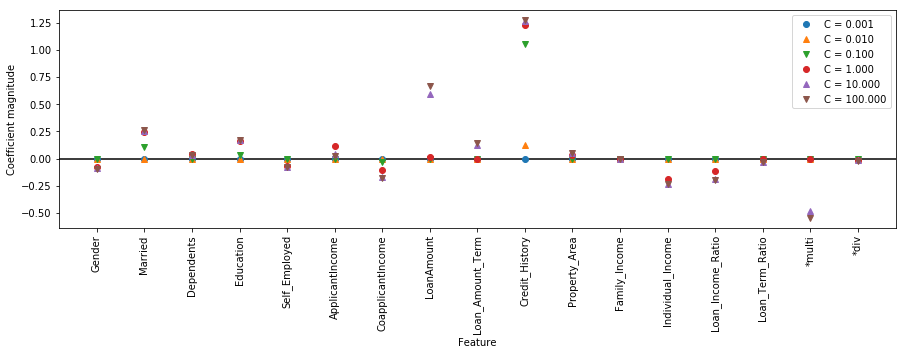

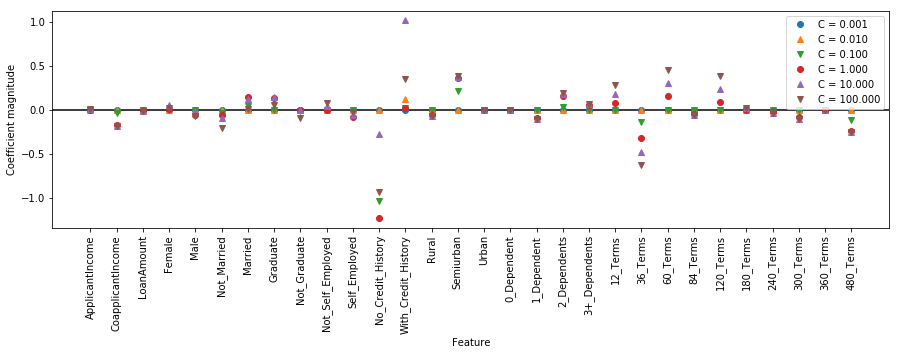

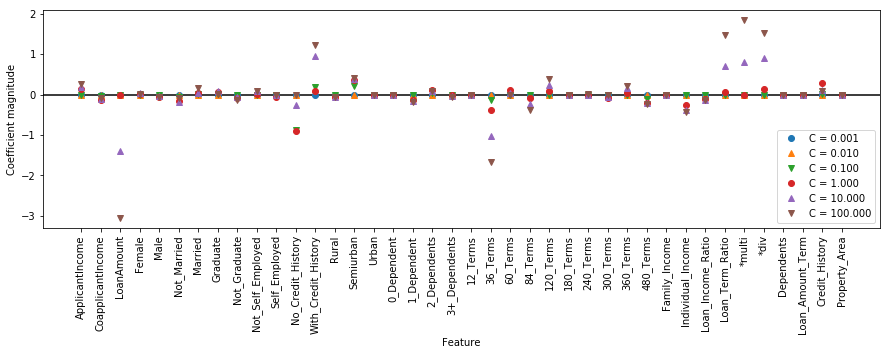

In [50]:
def features_importance_analysis(X_train, y_train, X_test, y_test):
    fig = plt.figure(figsize=(15, 4))
    for C, marker in zip([0.001, 0.01, 0.1, 1, 10, 100], ['o', '^', 'v', 'o', '^', 'v']):
        lr_l1 = LogisticRegression(C = C, penalty = "l1", solver = "liblinear").fit(X_train, y_train)
        #print("Train accuracy of l1 logreg with C = {:.3f}: {:.2f}".format(C, lr_l1.score(X_train, y_train)))
        #print("Test accuracy of l1 logreg with  C = {:.3f}: {:.2f}".format(C, lr_l1.score(X_test,  y_test)))
        plt.plot(lr_l1.coef_.T, marker, label = "C = {:.3f}".format(C))
    plt.xticks(range(len(X_train.columns)), X_train.columns, rotation=90)
    xlims = plt.xlim()
    plt.hlines(0, xlims[0], xlims[1])
    plt.xlim(xlims)
    plt.xlabel("Feature")
    plt.ylabel("Coefficient magnitude")
    plt.ylim()
    plt.legend();

features_importance_analysis(X_train_num_scaled,      y_train_num,      X_test_num_scaled,      y_test_num)
features_importance_analysis(X_train_1hot_scaled,     y_train_1hot,     X_test_1hot_scaled,     y_test_1hot)
features_importance_analysis(X_train_num_1hot_scaled, y_train_num_1hot, X_test_num_1hot_scaled, y_test_num_1hot)

L1 Regularisation with different C values are compared and plotted. There are zero-coefficient features in each data preprocessing methods,  which indicates they did not contribute too much in the modelling. For example,

1) in Numerical  
    Family Income  

2) in 1-hot  
    Loan Amount in 1-hot  
    whether there is 0-dependent in the family  
    whether there are 360 terms for the loan  

3) in Numerical + 1-hot  
    whether the family lives in urban area  
    whether there is 0-dependent in the family  
    whether there are 12 terms for the loan  
    whether there are 180 terms for the loan  
    Family Income  

These are the candidates for feature selection. However, the result above is only for logistic regression model built before, not for all the other algorithms. So no feature selection will be considered in this stage.

#### 4.1.2 SVC

Support Vetor Classifier is the second classifier to be tested on the data set.Only the numerical data preprocessing is tested in this section. The data sets using the other two preprocessing strategies will be tested in model tuning part later on.

In [51]:
print("Try linear and polynomial kernels on dataset after numerical preprocessing:")
svc_model_num_linear = SVC(kernel = 'linear')
svc_model_num_linear.fit(X_train_num_scaled, y_train_num)
print("Using 'linear' as kernel, accuracy on train set: {:.2f}".format(svc_model_num_linear.score(X_train_num_scaled, y_train_num)))
print("Using 'linear' as kernel, accuracy on test set:  {:.2f}".format(svc_model_num_linear.score(X_test_num_scaled,  y_test_num)))
svc_model_num_poly = SVC(kernel = 'poly')
svc_model_num_poly.fit(X_train_num_scaled, y_train_num)
print("Using 'poly'   as kernel, accuracy on train set: {:.2f}".format(svc_model_num_poly.score(X_train_num_scaled, y_train_num)))
print("Using 'poly'   as kernel, accuracy on test set:  {:.2f}".format(svc_model_num_poly.score(X_test_num_scaled,  y_test_num)))

Try linear and polynomial kernels on dataset after numerical preprocessing:
Using 'linear' as kernel, accuracy on train set: 0.80
Using 'linear' as kernel, accuracy on test set:  0.85
Using 'poly'   as kernel, accuracy on train set: 0.83
Using 'poly'   as kernel, accuracy on test set:  0.85


For this initial test on SVC, we found the accuracy on train sets are smaller than that on test set on both linear kernel and polynomial kernel. It may be due to under-fitting of both models. Hence, C is scanned to reduce the regularisation.

In [52]:
for C in [1, 5, 10, 50, 100]:
    svc_model_num_C = SVC(kernel = 'linear', C = C)
    svc_model_num_C.fit(X_train_num_scaled, y_train_num)
    print("Using 'linear' as kernel, accuracy on train set: {:.10f}".format(svc_model_num_C.score(X_train_num_scaled, y_train_num)))
    print("Using 'linear' as kernel, accuracy on test set:  {:.10f}".format(svc_model_num_C.score(X_test_num_scaled,  y_test_num)))
    #plt.plot(svc_model_num.score(X_train_num_scaled, y_train_num))

Using 'linear' as kernel, accuracy on train set: 0.7979591837
Using 'linear' as kernel, accuracy on test set:  0.8536585366
Using 'linear' as kernel, accuracy on train set: 0.7979591837
Using 'linear' as kernel, accuracy on test set:  0.8536585366
Using 'linear' as kernel, accuracy on train set: 0.7979591837
Using 'linear' as kernel, accuracy on test set:  0.8536585366
Using 'linear' as kernel, accuracy on train set: 0.7979591837
Using 'linear' as kernel, accuracy on test set:  0.8536585366
Using 'linear' as kernel, accuracy on train set: 0.7979591837
Using 'linear' as kernel, accuracy on test set:  0.8536585366


However, it does not help much by only increasing the C value. Check the confusion matrix.

In [53]:
y_train_pred = svc_model_num_C.predict(X_train_num_scaled)
y_test_pred  = svc_model_num_C.predict(X_test_num_scaled)
print("Confusion Matrix(train):")
print(confusion_matrix(y_train_num, y_train_pred))
print()
print("Confusion Matrix(test):")
print(confusion_matrix(y_test_num,  y_test_pred))

Confusion Matrix(train):
[[ 60  93]
 [  6 331]]

Confusion Matrix(test):
[[21 17]
 [ 1 84]]


By printing the confusion matrix of train and test sets, it can be seen that both of them are unbalanced set, and the TP are quite large comparing to FP and FN. That's why the precision and recall are both relatively high.

In [54]:
print("Accuracy(train):  " + str(accuracy_score(y_train_num, y_train_pred)))
print("Precision(train): " + str(precision_score(y_train_num, y_train_pred)) + " = 331 / (331 + 93)")
print("Recall(train):    " + str(recall_score(y_train_num, y_train_pred))    + " = 331 / (331 + 6)")
print("F1_score(train):  " + str(f1_score(y_train_num, y_train_pred)))

Accuracy(train):  0.7979591836734694
Precision(train): 0.7806603773584906 = 331 / (331 + 93)
Recall(train):    0.9821958456973294 = 331 / (331 + 6)
F1_score(train):  0.8699080157687253


In [55]:
print("Accuracy(test):  " + str(accuracy_score(y_test_num, y_test_pred)))
print("Precision(test): " + str(precision_score(y_test_num, y_test_pred)) + " = 84 / (84 + 17)")
print("Recall(test):    " + str(recall_score(y_test_num, y_test_pred))    + " = 84 / (84 + 1)")
print("F1_score(test):  " + str(f1_score(y_test_num, y_test_pred)))

Accuracy(test):  0.8536585365853658
Precision(test): 0.8316831683168316 = 84 / (84 + 17)
Recall(test):    0.9882352941176471 = 84 / (84 + 1)
F1_score(test):  0.903225806451613


By looking at the confusion matrix again, FP is larger than FN, which means there are 93 application cases in the train set should be approved, but rejected. 6 application cases should be rejected, but approved by the model. This model can help the bank choose customers safely. However, the bank may also lose customers due to its high FP. Hence, to balance the Precision and Recall, F1 score seems more suitable than Accuracy in tuning the model in section 4.2. 

The SVC model trained in section 4.2.3.2 by polynomial SVC with scoring of "f1" balances the FP and FN, also shows higher accuracy.  
Confusion Matrix(train):  
 [[ 74  79]  
  [  5 332]]  
Confusion Matrix(test):  
[[22 16]  
  [ 2 83]] 

The instances number of data set is relatively small. If more data can be collected, a more powerful model can be trained.

#### 4.1.3 Decision Tree

Decision Tree Classifier is tested on the numerical data set. Initially, there is over-fitting problem. But, after adding pre-pruning to the model, the over-fitting problem is alleviated. Feature importances are also checked. Only 1 feature matters (determines the result) in the second model built, probably because of the setting of max_depth as 1. More parameters scanning will be tried in section 4.2.4 to find the best model.

In [56]:
DTC_model = DecisionTreeClassifier()
parameters_range = {'criterion': ['gini'], 'splitter': ['best']}
grid = GridSearchCV(DTC_model, parameters_range, cv = 5, scoring = 'f1', n_jobs = -1)
grid.fit(X_train_num_scaled, y_train_num)
#print_best_params_score(grid)
y_train_pred   = grid.best_estimator_.predict(X_train_num_scaled)
y_test_pred    = grid.best_estimator_.predict(X_test_num_scaled)
print("Confusion Matrix (train):")
print(confusion_matrix(y_train_num,      y_train_pred))
print("Confusion Matrix (test):")
print(confusion_matrix(y_test_num,       y_test_pred))
accuracy_train  = accuracy_score(y_train_num, y_train_pred)
accuracy_test   = accuracy_score(y_test_num,  y_test_pred)
print("Train Accuracy:  {var:.4f}".format(var = accuracy_train))  
print("Test  Accuracy:  {var:.4f}".format(var = accuracy_test)) 
print("Feature Importances in the Decision Tree model:")
print(grid.best_estimator_.feature_importances_)

Confusion Matrix (train):
[[153   0]
 [  0 337]]
Confusion Matrix (test):
[[24 14]
 [22 63]]
Train Accuracy:  1.0000
Test  Accuracy:  0.7073
Feature Importances in the Decision Tree model:
[0.00633554 0.01928528 0.0178187  0.0199302  0.00226133 0.12057576
 0.04134657 0.05961471 0.01427665 0.25821026 0.03111467 0.08048828
 0.12774528 0.09847408 0.03904838 0.02101081 0.04246349]


In [57]:
DTC_model = DecisionTreeClassifier()
parameters_range = {'criterion': ['gini'], 'splitter': ['best'], 'max_depth': [1], 'max_leaf_nodes': [2], 'min_samples_split': [2], 'min_samples_leaf':  [1]}
grid = GridSearchCV(DTC_model, parameters_range, cv = 5, scoring = 'f1', n_jobs = -1)
grid.fit(X_train_num_scaled, y_train_num)
#print_best_params_score(grid)
y_train_pred   = grid.best_estimator_.predict(X_train_num_scaled)
y_test_pred    = grid.best_estimator_.predict(X_test_num_scaled)
print("Confusion Matrix (train):")
print(confusion_matrix(y_train_num,      y_train_pred))
print("Confusion Matrix (test):")
print(confusion_matrix(y_test_num,       y_test_pred))
accuracy_train  = accuracy_score(y_train_num, y_train_pred)
accuracy_test   = accuracy_score(y_test_num,  y_test_pred)
print("Train Accuracy:  {var:.4f}".format(var = accuracy_train))  
print("Test  Accuracy:  {var:.4f}".format(var = accuracy_test))
print("Feature Importances in the Decision Tree model:")
print(grid.best_estimator_.feature_importances_)

Confusion Matrix (train):
[[ 60  93]
 [  6 331]]
Confusion Matrix (test):
[[21 17]
 [ 1 84]]
Train Accuracy:  0.7980
Test  Accuracy:  0.8537
Feature Importances in the Decision Tree model:
[0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]


## 4.2 Models Tuning

Before training models, several useful functions can be defined.   
And, in this project f1 score seems more intuitive in comparing among models, which also can balance the model (the reason was discussed in section 4.1.2). Also, when using 'roc_auc' as scoring, some errors emerge probalbly due to the data pre-processing methods. Hence, f1 score is chosen for tuning the model. ROC AUC will be used to do comparison among models.

In [58]:
def print_best_params_score(grid):
    best_params    = grid.best_params_
    best_estimator = grid.best_estimator_
    best_score     = grid.best_score_
    print("Best Parameters:")
    print(best_params)
    print("Best F1 Score:")
    print(best_score)

In [59]:
def print_performance_measure(y_train, y_train_pred, y_test, y_test_pred, df_algorithm_performance, df_all_models_performance, model_name):
    accuracy_train  = accuracy_score(y_train, y_train_pred)
    accuracy_test   = accuracy_score(y_test,  y_test_pred)
    #print('Train Accuracy:  {var:.4f}'.format(var = accuracy_train))  
    #print('Test  Accuracy:  {var:.4f}'.format(var = accuracy_test)) 
    precision_train = precision_score(y_train, y_train_pred)
    precision_test  = precision_score(y_test, y_test_pred)
    #print('Train Precision: {var:.4f}'.format(var = precision_train))
    #print('Test  Precision: {var:.4f}'.format(var = precision_test))
    recall_train    = recall_score(y_train, y_train_pred)
    recall_test     = recall_score(y_test,  y_test_pred)
    #print('Train Recall:    {var:.4f}'.format(var = recall_train))
    #print('Test  Recall:    {var:.4f}'.format(var = recall_test))
    f1_train        = f1_score(y_train, y_train_pred)
    f1_test         = f1_score(y_test,  y_test_pred)
    #print('Train F1_Score:  {var:.4f}'.format(var = f1_train))
    #print('Test  F1_Score:  {var:.4f}'.format(var = f1_test))
    auc_train       = roc_auc_score(y_train, y_train_pred)
    auc_test        = roc_auc_score(y_test,  y_test_pred)
    #print('Train AUC:       {var:.4f}'.format(var = auc_train))
    #print('Test  AUC:       {var:.4f}'.format(var = auc_test))
    df_model_performance = pd.DataFrame(index = ['Train Accuracy',  'Test Accuracy', 'Train Precision', 'Test Precision', 'Train Recall',    'Test Recall',
                                                 'Train F1_Score',  'Test F1_Score', 'Train AUC',       'Test AUC'],
                                        data = {model_name: [accuracy_train, accuracy_test, precision_train, precision_test, recall_train, recall_test,
                                                       f1_train, f1_test, auc_train, auc_test]})
    df_algorithm_performance  = pd.concat([df_algorithm_performance,  df_model_performance], axis=1)
    df_all_models_performance = pd.concat([df_all_models_performance, df_model_performance], axis=1)
    return df_algorithm_performance, df_all_models_performance

In [60]:
def compare_pred_label(pred, label):
    df_label = pd.DataFrame({'Loan_ID':label.index, 'Label':label.values})
    df_label.set_index('Loan_ID', inplace = True)
    df_comp  = pd.concat([pd.DataFrame(pred, index = y_train_num.index, columns = ["Pred"]), df_label], axis=1)
    #print(df_comp.head())
    wrong_pred_index = df_comp.index[df_comp['Pred'] != df_comp['Label']].tolist()
    #print(wrong_pred_index)
    df_train_num_wrong_pred = df_train_num.loc[wrong_pred_index]
    print(df_train_num_wrong_pred)

In [61]:
df_all_models_performance    = pd.DataFrame(index = ['Train Accuracy',  'Test Accuracy', 'Train Precision', 'Test Precision', 'Train Recall', 'Test Recall', 'Train F1_Score', 'Test F1_Score', 'Train AUC', 'Test AUC'])
df_KNN_algorithm_performance = pd.DataFrame(index = ['Train Accuracy',  'Test Accuracy', 'Train Precision', 'Test Precision', 'Train Recall', 'Test Recall', 'Train F1_Score', 'Test F1_Score', 'Train AUC', 'Test AUC'])
df_GNB_algorithm_performance = pd.DataFrame(index = ['Train Accuracy',  'Test Accuracy', 'Train Precision', 'Test Precision', 'Train Recall', 'Test Recall', 'Train F1_Score', 'Test F1_Score', 'Train AUC', 'Test AUC'])
df_SVC_algorithm_performance = pd.DataFrame(index = ['Train Accuracy',  'Test Accuracy', 'Train Precision', 'Test Precision', 'Train Recall', 'Test Recall', 'Train F1_Score', 'Test F1_Score', 'Train AUC', 'Test AUC'])
df_DTC_algorithm_performance = pd.DataFrame(index = ['Train Accuracy',  'Test Accuracy', 'Train Precision', 'Test Precision', 'Train Recall', 'Test Recall', 'Train F1_Score', 'Test F1_Score', 'Train AUC', 'Test AUC'])
df_RFC_algorithm_performance = pd.DataFrame(index = ['Train Accuracy',  'Test Accuracy', 'Train Precision', 'Test Precision', 'Train Recall', 'Test Recall', 'Train F1_Score', 'Test F1_Score', 'Train AUC', 'Test AUC'])
df_ABC_algorithm_performance = pd.DataFrame(index = ['Train Accuracy',  'Test Accuracy', 'Train Precision', 'Test Precision', 'Train Recall', 'Test Recall', 'Train F1_Score', 'Test F1_Score', 'Train AUC', 'Test AUC'])
df_GBC_algorithm_performance = pd.DataFrame(index = ['Train Accuracy',  'Test Accuracy', 'Train Precision', 'Test Precision', 'Train Recall', 'Test Recall', 'Train F1_Score', 'Test F1_Score', 'Train AUC', 'Test AUC'])
df_LDA_algorithm_performance = pd.DataFrame(index = ['Train Accuracy',  'Test Accuracy', 'Train Precision', 'Test Precision', 'Train Recall', 'Test Recall', 'Train F1_Score', 'Test F1_Score', 'Train AUC', 'Test AUC'])
df_MLP_algorithm_performance = pd.DataFrame(index = ['Train Accuracy',  'Test Accuracy', 'Train Precision', 'Test Precision', 'Train Recall', 'Test Recall', 'Train F1_Score', 'Test F1_Score', 'Train AUC', 'Test AUC'])
df_LR_algorithm_performance  = pd.DataFrame(index = ['Train Accuracy',  'Test Accuracy', 'Train Precision', 'Test Precision', 'Train Recall', 'Test Recall', 'Train F1_Score', 'Test F1_Score', 'Train AUC', 'Test AUC'])

### 4.2.1 KNN

In [62]:
def pred_KNN(KNN_model, X_train, X_test, y_train):
    parameters_range = {'n_neighbors': range(1, 30, 1),
                        'weights':     ['uniform', 'distance'],
                        'algorithm':   ['ball_tree', 'kd_tree', 'brute', 'auto'],
                        'leaf_size':   range(1,10,1),
                        'p':           [1, 2]
                       }
    grid = GridSearchCV(KNN_model, 
                        parameters_range, 
                        cv      = 5,
                        scoring = 'f1',
                        n_jobs  = -1)
    grid.fit(X_train, y_train)
    print_best_params_score(grid)
    y_train_pred   = grid.best_estimator_.predict(X_train)
    y_test_pred    = grid.best_estimator_.predict(X_test)
    return y_train_pred, y_test_pred, grid.best_estimator_

In [63]:
KNN_model = KNeighborsClassifier()
# numerical
y_train_pred, y_test_pred, KNN_model_num      = pred_KNN(KNeighborsClassifier(), X_train_num_scaled,      X_test_num_scaled,      y_train_num)
df_KNN_algorithm_performance, df_all_models_performance = print_performance_measure(y_train_num,      y_train_pred, y_test_num,      y_test_pred, df_KNN_algorithm_performance, df_all_models_performance, 'KNN(Num)')
# 1-hot
y_train_pred, y_test_pred, KNN_model_1hot     = pred_KNN(KNeighborsClassifier(), X_train_1hot_scaled,     X_test_1hot_scaled,     y_train_1hot)
df_KNN_algorithm_performance, df_all_models_performance = print_performance_measure(y_train_1hot,     y_train_pred, y_test_1hot,     y_test_pred, df_KNN_algorithm_performance, df_all_models_performance, 'KNN(1-hot)')
# numerical + 1_hot
y_train_pred, y_test_pred, KNN_model_num_1hot = pred_KNN(KNeighborsClassifier(), X_train_num_1hot_scaled, X_test_num_1hot_scaled, y_train_num_1hot)
df_KNN_algorithm_performance, df_all_models_performance = print_performance_measure(y_train_num_1hot, y_train_pred, y_test_num_1hot, y_test_pred, df_KNN_algorithm_performance, df_all_models_performance, 'KNN(comb)')
df_KNN_algorithm_performance

Best Parameters:
{'algorithm': 'ball_tree', 'leaf_size': 1, 'n_neighbors': 15, 'p': 2, 'weights': 'distance'}
Best F1 Score:
0.8676779944297998
Best Parameters:
{'algorithm': 'ball_tree', 'leaf_size': 1, 'n_neighbors': 20, 'p': 2, 'weights': 'uniform'}
Best F1 Score:
0.8702656961771655
Best Parameters:
{'algorithm': 'ball_tree', 'leaf_size': 1, 'n_neighbors': 22, 'p': 2, 'weights': 'uniform'}
Best F1 Score:
0.8725404367792029


,KNN(Num),KNN(1-hot),KNN(comb)
Train Accuracy,1.000000,0.797959,0.797959
Test Accuracy,0.837398,0.845528,0.845528
Train Precision,1.000000,0.780660,0.780660
Test Precision,0.821782,0.823529,0.823529
Train Recall,1.000000,0.982196,0.982196
Test Recall,0.976471,0.988235,0.988235
Train F1_Score,1.000000,0.869908,0.869908
Test F1_Score,0.892473,0.898396,0.898396
Train AUC,1.000000,0.687176,0.687176
Test AUC,0.751393,0.757276,0.757276


### 4.2.2 GaussianNB

In [64]:
def pred_GNB(GNB_model, X_train, X_test, y_train, y_test):
    parameters_range = {}
    grid = GridSearchCV(GNB_model, 
                        parameters_range, 
                        cv      = 5,
                        scoring = 'f1',
                        n_jobs  = -1)
    grid.fit(X_train, y_train)
    print_best_params_score(grid)
    y_train_pred   = grid.best_estimator_.predict(X_train)
    y_test_pred    = grid.best_estimator_.predict(X_test)
    print(confusion_matrix(y_train,      y_train_pred))
    print(confusion_matrix(y_test,       y_test_pred))
    return y_train_pred, y_test_pred, grid.best_estimator_

In [65]:
GNB_model = GaussianNB()
# numerical
y_train_pred, y_test_pred, GNB_model_num      = pred_GNB(GaussianNB(), X_train_num_scaled,      X_test_num_scaled,      y_train_num, y_test_num)
df_GNB_algorithm_performance, df_all_models_performance = print_performance_measure(y_train_num,      y_train_pred, y_test_num,      y_test_pred, df_GNB_algorithm_performance, df_all_models_performance, 'GNB(Num)')
# 1-hot
y_train_pred, y_test_pred, GNB_model_1hot     = pred_GNB(GaussianNB(), X_train_1hot_scaled,     X_test_1hot_scaled,     y_train_1hot, y_test_1hot)
df_GNB_algorithm_performance, df_all_models_performance = print_performance_measure(y_train_1hot,     y_train_pred, y_test_1hot,     y_test_pred, df_GNB_algorithm_performance, df_all_models_performance, 'GNB(1-hot)')
# numerical + 1_hot
y_train_pred, y_test_pred, GNB_model_num_1hot = pred_GNB(GaussianNB(), X_train_num_1hot_scaled, X_test_num_1hot_scaled, y_train_num_1hot, y_test_num_1hot)
df_GNB_algorithm_performance, df_all_models_performance = print_performance_measure(y_train_num_1hot, y_train_pred, y_test_num_1hot, y_test_pred, df_GNB_algorithm_performance, df_all_models_performance, 'GNB(comb)')
df_GNB_algorithm_performance

Best Parameters:
{}
Best F1 Score:
0.8419331807892072
[[ 68  85]
 [ 10 327]]
[[24 14]
 [ 3 82]]
Best Parameters:
{}
Best F1 Score:
0.017392895046217244
[[152   1]
 [326  11]]
[[38  0]
 [83  2]]
Best Parameters:
{}
Best F1 Score:
0.060235160554697915
[[151   2]
 [326  11]]
[[38  0]
 [83  2]]


,GNB(Num),GNB(1-hot),GNB(comb)
Train Accuracy,0.806122,0.332653,0.330612
Test Accuracy,0.861789,0.325203,0.325203
Train Precision,0.793689,0.916667,0.846154
Test Precision,0.854167,1.000000,1.000000
Train Recall,0.970326,0.032641,0.032641
Test Recall,0.964706,0.023529,0.023529
Train F1_Score,0.873164,0.063037,0.062857
Test F1_Score,0.906077,0.045977,0.045977
Train AUC,0.707385,0.513053,0.509785
Test AUC,0.798142,0.511765,0.511765


### 4.2.3 SVC

#### 4.2.3.1 Linear_SVC

In [66]:
def pred_SVC(SVC_model, X_train, X_test, y_train, y_test):
    parameters_range = {'C':           [0.0005, 0.0008, 0.001, 0.0012, 0.0015, 0.0017, 0.002, 0.0025, 0.0028, 0.003, 0.0032, 0.0035, 0.004, 0.005],
                        'kernel':      ['linear', 'poly', 'rbf', 'sigmoid'],
                        'shrinking':   [False, True],
                       }
    grid = GridSearchCV(SVC_model, 
                        parameters_range, 
                        cv      = 5,
                        scoring = 'f1',
                        n_jobs  = -1)
    grid.fit(X_train, y_train)

    print_best_params_score(grid)

    y_train_pred   = grid.best_estimator_.predict(X_train)
    y_test_pred    = grid.best_estimator_.predict(X_test)
    print(confusion_matrix(y_train,      y_train_pred))
    print(confusion_matrix(y_test,       y_test_pred))
    return y_train_pred, y_test_pred, grid.best_estimator_

In [67]:
SVC_model = SVC()
# numerical
y_train_pred, y_test_pred, SVC_model_num      = pred_SVC(SVC(), X_train_num_scaled,      X_test_num_scaled,      y_train_num, y_test_num)
df_SVC_algorithm_performance, df_all_models_performance = print_performance_measure(y_train_num,      y_train_pred, y_test_num,      y_test_pred, df_SVC_algorithm_performance, df_all_models_performance, 'SVC(Num)')
# 1-hot
y_train_pred, y_test_pred, SVC_model_1hot     = pred_SVC(SVC(), X_train_1hot_scaled,     X_test_1hot_scaled,     y_train_1hot, y_test_1hot)
df_SVC_algorithm_performance, df_all_models_performance = print_performance_measure(y_train_1hot,     y_train_pred, y_test_1hot,     y_test_pred, df_SVC_algorithm_performance, df_all_models_performance, 'SVC(1-hot)')
# numerical + 1_hot
y_train_pred, y_test_pred, SVC_model_num_1hot = pred_SVC(SVC(), X_train_num_1hot_scaled, X_test_num_1hot_scaled, y_train_num_1hot, y_test_num_1hot)
df_SVC_algorithm_performance, df_all_models_performance = print_performance_measure(y_train_num_1hot, y_train_pred, y_test_num_1hot, y_test_pred, df_SVC_algorithm_performance, df_all_models_performance, 'SVC(comb)')
df_SVC_algorithm_performance

Best Parameters:
{'C': 0.0028, 'kernel': 'linear', 'shrinking': False}
Best F1 Score:
0.8699165300736637
[[ 60  93]
 [  6 331]]
[[21 17]
 [ 1 84]]
Best Parameters:
{'C': 0.0015, 'kernel': 'linear', 'shrinking': False}
Best F1 Score:
0.8699165300736637
[[ 60  93]
 [  6 331]]
[[21 17]
 [ 1 84]]
Best Parameters:
{'C': 0.001, 'kernel': 'linear', 'shrinking': False}
Best F1 Score:
0.8699165300736637
[[ 60  93]
 [  6 331]]
[[21 17]
 [ 1 84]]


,SVC(Num),SVC(1-hot),SVC(comb)
Train Accuracy,0.797959,0.797959,0.797959
Test Accuracy,0.853659,0.853659,0.853659
Train Precision,0.780660,0.780660,0.780660
Test Precision,0.831683,0.831683,0.831683
Train Recall,0.982196,0.982196,0.982196
Test Recall,0.988235,0.988235,0.988235
Train F1_Score,0.869908,0.869908,0.869908
Test F1_Score,0.903226,0.903226,0.903226
Train AUC,0.687176,0.687176,0.687176
Test AUC,0.770433,0.770433,0.770433


#### 4.2.3.2 Polynomial SVC

In [68]:
def pred_Poly_SVC(Poly_SVC_model, X_train, X_test, y_train, y_test):
    parameters_range = {'C':           [0.0005, 0.0008, 0.001, 0.0012, 0.0015, 0.0017, 0.002, 0.0025, 0.0028, 0.003, 0.0032, 0.0035, 0.004, 0.005],
                        'kernel':      ['poly'],
                        'degree':      [1, 2, 3, 4, 5], # !!!!!
                        'shrinking':   [False, True],
                        'gamma':       [0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1, 5, 10, 50]
                       }
    grid = GridSearchCV(Poly_SVC_model, 
                        parameters_range, 
                        cv      = 5,
                        scoring = 'f1',
                        n_jobs  = -1)
    grid.fit(X_train, y_train)
    print_best_params_score(grid)
    y_train_pred   = grid.best_estimator_.predict(X_train)
    y_test_pred    = grid.best_estimator_.predict(X_test)
    print(confusion_matrix(y_train,      y_train_pred))
    print(confusion_matrix(y_test,       y_test_pred))
    return y_train_pred, y_test_pred, grid.best_estimator_

In [69]:
Poly_SVC_model = SVC()
# numerical
y_train_pred, y_test_pred, Poly_SVC_model_num      = pred_Poly_SVC(SVC(), X_train_num_scaled,      X_test_num_scaled,      y_train_num, y_test_num)
df_SVC_algorithm_performance, df_all_models_performance = print_performance_measure(y_train_num,      y_train_pred, y_test_num,      y_test_pred, df_SVC_algorithm_performance, df_all_models_performance, 'Poly_SVC(Num)')
# 1-hot
y_train_pred, y_test_pred, Poly_SVC_model_1hot     = pred_Poly_SVC(SVC(), X_train_1hot_scaled,     X_test_1hot_scaled,     y_train_1hot, y_test_1hot)
df_SVC_algorithm_performance, df_all_models_performance = print_performance_measure(y_train_1hot,     y_train_pred, y_test_1hot,     y_test_pred, df_SVC_algorithm_performance, df_all_models_performance, 'Poly_SVC(1-hot)')
# numerical + 1_hot
y_train_pred, y_test_pred, Poly_SVC_model_num_1hot = pred_Poly_SVC(SVC(), X_train_num_1hot_scaled, X_test_num_1hot_scaled, y_train_num_1hot, y_test_num_1hot)
df_SVC_algorithm_performance, df_all_models_performance = print_performance_measure(y_train_num_1hot, y_train_pred, y_test_num_1hot, y_test_pred, df_SVC_algorithm_performance, df_all_models_performance, 'Poly_SVC(comb)')
df_SVC_algorithm_performance

Best Parameters:
{'C': 0.0005, 'degree': 1, 'gamma': 10, 'kernel': 'poly', 'shrinking': False}
Best F1 Score:
0.8699165300736637
[[ 60  93]
 [  6 331]]
[[21 17]
 [ 1 84]]
Best Parameters:
{'C': 0.0005, 'degree': 1, 'gamma': 5, 'kernel': 'poly', 'shrinking': False}
Best F1 Score:
0.8699165300736637
[[ 62  91]
 [  6 331]]
[[21 17]
 [ 1 84]]
Best Parameters:
{'C': 0.0005, 'degree': 1, 'gamma': 5, 'kernel': 'poly', 'shrinking': False}
Best F1 Score:
0.8699165300736637
[[ 62  91]
 [  6 331]]
[[21 17]
 [ 1 84]]


,SVC(Num),SVC(1-hot),SVC(comb),Poly_SVC(Num),Poly_SVC(1-hot),Poly_SVC(comb)
Train Accuracy,0.797959,0.797959,0.797959,0.797959,0.802041,0.802041
Test Accuracy,0.853659,0.853659,0.853659,0.853659,0.853659,0.853659
Train Precision,0.780660,0.780660,0.780660,0.780660,0.784360,0.784360
Test Precision,0.831683,0.831683,0.831683,0.831683,0.831683,0.831683
Train Recall,0.982196,0.982196,0.982196,0.982196,0.982196,0.982196
Test Recall,0.988235,0.988235,0.988235,0.988235,0.988235,0.988235
Train F1_Score,0.869908,0.869908,0.869908,0.869908,0.872200,0.872200
Test F1_Score,0.903226,0.903226,0.903226,0.903226,0.903226,0.903226
Train AUC,0.687176,0.687176,0.687176,0.687176,0.693712,0.693712
Test AUC,0.770433,0.770433,0.770433,0.770433,0.770433,0.770433


### 4.2.4 Decision Tree Classifier

In [70]:
def pred_DTC(DTC_model, X_train, X_test, y_train, y_test):
    parameters_range = {'criterion':          ['gini', 'entropy'],
                        'splitter':           ['best', 'random'],
                        'max_depth':          range(1, 10, 1),
                        'max_leaf_nodes':     range(2, 10, 1),
                        'min_samples_split':  range(2, 10, 1),
                        'min_samples_leaf':   range(1, 10, 1),
                        #'max_features':       range(1, n_features, 10),
                       }
    grid = GridSearchCV(DTC_model, 
                        parameters_range, 
                        cv      = 5,
                        scoring = 'f1',
                        n_jobs  = -1)
    grid.fit(X_train, y_train)
    print_best_params_score(grid)
    y_train_pred   = grid.best_estimator_.predict(X_train)
    y_test_pred    = grid.best_estimator_.predict(X_test)
    print(confusion_matrix(y_train,      y_train_pred))
    print(confusion_matrix(y_test,       y_test_pred))
    return y_train_pred, y_test_pred, grid.best_estimator_

In [71]:
DTC_model = DecisionTreeClassifier()
# numerical
y_train_pred, y_test_pred, DTC_model_num      = pred_DTC(DecisionTreeClassifier(), X_train_num_scaled,      X_test_num_scaled,      y_train_num, y_test_num)
df_DTC_algorithm_performance, df_all_models_performance = print_performance_measure(y_train_num,      y_train_pred, y_test_num,      y_test_pred, df_DTC_algorithm_performance, df_all_models_performance, 'DTC(Num)')
# 1-hot
y_train_pred, y_test_pred, DTC_model_1hot     = pred_DTC(DecisionTreeClassifier(), X_train_1hot_scaled,     X_test_1hot_scaled,     y_train_1hot, y_test_1hot)
df_DTC_algorithm_performance, df_all_models_performance = print_performance_measure(y_train_1hot,     y_train_pred, y_test_1hot,     y_test_pred, df_DTC_algorithm_performance, df_all_models_performance, 'DTC(1-hot)')
# numerical + 1_hot
y_train_pred, y_test_pred, DTC_model_num_1hot = pred_DTC(DecisionTreeClassifier(), X_train_num_1hot_scaled, X_test_num_1hot_scaled, y_train_num_1hot, y_test_num_1hot)
df_DTC_algorithm_performance, df_all_models_performance = print_performance_measure(y_train_num_1hot, y_train_pred, y_test_num_1hot, y_test_pred, df_DTC_algorithm_performance, df_all_models_performance, 'DTC(comb)')
df_DTC_algorithm_performance

Best Parameters:
{'criterion': 'gini', 'max_depth': 1, 'max_leaf_nodes': 8, 'min_samples_leaf': 3, 'min_samples_split': 4, 'splitter': 'random'}
Best F1 Score:
0.8769217852450862
[[ 60  93]
 [  6 331]]
[[21 17]
 [ 1 84]]
Best Parameters:
{'criterion': 'gini', 'max_depth': 1, 'max_leaf_nodes': 2, 'min_samples_leaf': 1, 'min_samples_split': 2, 'splitter': 'best'}
Best F1 Score:
0.8699165300736637
[[ 60  93]
 [  6 331]]
[[21 17]
 [ 1 84]]
Best Parameters:
{'criterion': 'entropy', 'max_depth': 2, 'max_leaf_nodes': 9, 'min_samples_leaf': 6, 'min_samples_split': 2, 'splitter': 'random'}
Best F1 Score:
0.8743262483338818
[[ 60  93]
 [  6 331]]
[[21 17]
 [ 1 84]]


,DTC(Num),DTC(1-hot),DTC(comb)
Train Accuracy,0.797959,0.797959,0.797959
Test Accuracy,0.853659,0.853659,0.853659
Train Precision,0.780660,0.780660,0.780660
Test Precision,0.831683,0.831683,0.831683
Train Recall,0.982196,0.982196,0.982196
Test Recall,0.988235,0.988235,0.988235
Train F1_Score,0.869908,0.869908,0.869908
Test F1_Score,0.903226,0.903226,0.903226
Train AUC,0.687176,0.687176,0.687176
Test AUC,0.770433,0.770433,0.770433


### 4.2.5 Random Forest Classifier

In [72]:
def pred_RFC(RFC_model, X_train, X_test, y_train):
    parameters_range = {'n_estimators':      [5, 10], #5
                        'criterion':         ['gini', 'entropy'],
                        'bootstrap':         [False, True],
                        'max_depth':         range(1, 10, 1),
                        'max_leaf_nodes':    range(2, 10, 1),
                        'min_samples_split': range(2, 10, 1),
                        'min_samples_leaf':  range(1, 10, 1)
                        }
    grid = GridSearchCV(RFC_model, 
                        parameters_range, 
                        cv      = 5,
                        scoring = 'f1',
                        n_jobs  = -1)
    grid.fit(X_train, y_train)
    print_best_params_score(grid)
    y_train_pred   = grid.best_estimator_.predict(X_train)
    y_test_pred    = grid.best_estimator_.predict(X_test)
    return y_train_pred, y_test_pred, grid.best_estimator_

In [73]:
RFC_model = RandomForestClassifier()
# numerical
y_train_pred, y_test_pred, RFC_model_num      = pred_RFC(RandomForestClassifier(), X_train_num_scaled,      X_test_num_scaled,      y_train_num)
df_RFC_algorithm_performance, df_all_models_performance = print_performance_measure(y_train_num,      y_train_pred, y_test_num,      y_test_pred, df_RFC_algorithm_performance, df_all_models_performance, 'RFC(Num)')
# 1-hot
y_train_pred, y_test_pred, RFC_model_1hot     = pred_RFC(RandomForestClassifier(), X_train_1hot_scaled,     X_test_1hot_scaled,     y_train_1hot)
df_RFC_algorithm_performance, df_all_models_performance = print_performance_measure(y_train_1hot,     y_train_pred, y_test_1hot,     y_test_pred, df_RFC_algorithm_performance, df_all_models_performance, 'RFC(1-hot)')
# numerical + 1_hot
y_train_pred, y_test_pred, RFC_model_num_1hot = pred_RFC(RandomForestClassifier(), X_train_num_1hot_scaled, X_test_num_1hot_scaled, y_train_num_1hot)
df_RFC_algorithm_performance, df_all_models_performance = print_performance_measure(y_train_num_1hot, y_train_pred, y_test_num_1hot, y_test_pred, df_RFC_algorithm_performance, df_all_models_performance, 'RFC(comb)')
df_RFC_algorithm_performance

Best Parameters:
{'bootstrap': True, 'criterion': 'entropy', 'max_depth': 6, 'max_leaf_nodes': 7, 'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 5}
Best F1 Score:
0.8765366623163624
Best Parameters:
{'bootstrap': True, 'criterion': 'gini', 'max_depth': 3, 'max_leaf_nodes': 4, 'min_samples_leaf': 3, 'min_samples_split': 9, 'n_estimators': 5}
Best F1 Score:
0.8748451070912853
Best Parameters:
{'bootstrap': True, 'criterion': 'entropy', 'max_depth': 9, 'max_leaf_nodes': 4, 'min_samples_leaf': 7, 'min_samples_split': 6, 'n_estimators': 5}
Best F1 Score:
0.8746739297222648


,RFC(Num),RFC(1-hot),RFC(comb)
Train Accuracy,0.812245,0.797959,0.797959
Test Accuracy,0.829268,0.845528,0.853659
Train Precision,0.789598,0.781991,0.780660
Test Precision,0.807692,0.830000,0.831683
Train Recall,0.991098,0.979228,0.982196
Test Recall,0.988235,0.976471,0.988235
Train F1_Score,0.878947,0.869565,0.869908
Test F1_Score,0.888889,0.897297,0.903226
Train AUC,0.704699,0.688961,0.687176
Test AUC,0.730960,0.764551,0.770433


### 4.2.6 Ada Boost Classifier

In [74]:
def pred_ABC(ABC_model, X_train, X_test, y_train):
    parameters_range = {'n_estimators':  [1, 5, 10, 50], # 1, 5
                        'learning_rate': [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1.0, 5.0, 10.0, 50.0, 100.0],
                        'algorithm':     ['SAMME', 'SAMME.R']
                       }
    grid = GridSearchCV(ABC_model, 
                        parameters_range, 
                        cv      = 5,
                        scoring = 'f1',
                        n_jobs  = -1)
    grid.fit(X_train, y_train)
    print_best_params_score(grid)
    y_train_pred   = grid.best_estimator_.predict(X_train)
    y_test_pred    = grid.best_estimator_.predict(X_test)
    return y_train_pred, y_test_pred, grid.best_estimator_

In [75]:
ABC_model = AdaBoostClassifier()
# numerical
y_train_pred, y_test_pred, ABC_model_num      = pred_ABC(AdaBoostClassifier(), X_train_num_scaled,      X_test_num_scaled,      y_train_num)
df_ABC_algorithm_performance, df_all_models_performance = print_performance_measure(y_train_num,      y_train_pred, y_test_num,      y_test_pred, df_ABC_algorithm_performance, df_all_models_performance, 'ABC(Num)')
# 1-hot
y_train_pred, y_test_pred, ABC_model_1hot     = pred_ABC(AdaBoostClassifier(), X_train_1hot_scaled,     X_test_1hot_scaled,     y_train_1hot)
df_ABC_algorithm_performance, df_all_models_performance = print_performance_measure(y_train_1hot,     y_train_pred, y_test_1hot,     y_test_pred, df_ABC_algorithm_performance, df_all_models_performance, 'ABC(1-hot)')
# numerical + 1_hot
y_train_pred, y_test_pred, ABC_model_num_1hot = pred_ABC(AdaBoostClassifier(), X_train_num_1hot_scaled, X_test_num_1hot_scaled, y_train_num_1hot)
df_ABC_algorithm_performance, df_all_models_performance = print_performance_measure(y_train_num_1hot, y_train_pred, y_test_num_1hot, y_test_pred, df_ABC_algorithm_performance, df_all_models_performance, 'ABC(comb)')
df_ABC_algorithm_performance

Best Parameters:
{'algorithm': 'SAMME.R', 'learning_rate': 0.5, 'n_estimators': 5}
Best F1 Score:
0.8707005620552261
Best Parameters:
{'algorithm': 'SAMME', 'learning_rate': 0.001, 'n_estimators': 1}
Best F1 Score:
0.8699165300736637
Best Parameters:
{'algorithm': 'SAMME', 'learning_rate': 0.001, 'n_estimators': 1}
Best F1 Score:
0.8699165300736637


,ABC(Num),ABC(1-hot),ABC(comb)
Train Accuracy,0.806122,0.797959,0.797959
Test Accuracy,0.853659,0.853659,0.853659
Train Precision,0.789474,0.780660,0.780660
Test Precision,0.845361,0.831683,0.831683
Train Recall,0.979228,0.982196,0.982196
Test Recall,0.964706,0.988235,0.988235
Train F1_Score,0.874172,0.869908,0.869908
Test F1_Score,0.901099,0.903226,0.903226
Train AUC,0.702033,0.687176,0.687176
Test AUC,0.784985,0.770433,0.770433


### 4.2.7 Gradient Boosting Classifier

In [76]:
def pred_GBC(GBC_model, X_train, X_test, y_train):
    parameters_range = {'loss':                     ['deviance', 'exponential'],
                        'learning_rate':            [0.01, 0.05, 0.1, 0.5, 1.0, 5.0],
                        'n_estimators':             [1, 5, 10, 50, 100],
                        'criterion':                ['mse'],
                        'subsample':                [0.8, 0.9],
                        'min_samples_split':        range(2, 10, 1),
                        'min_samples_leaf':         range(1, 10, 1),
                        #'min_weight_fraction_leaf': [0, 0.1, 0.2, 0.3, 0.4, 0.5],
                        'max_depth':                range(1, 3, 1),
                        }
    grid = GridSearchCV(GBC_model, 
                        parameters_range, 
                        cv      = 5,
                        scoring = 'f1',
                        n_jobs  = -1)
    grid.fit(X_train, y_train)
    print_best_params_score(grid)
    y_train_pred   = grid.best_estimator_.predict(X_train)
    y_test_pred    = grid.best_estimator_.predict(X_test)
    return y_train_pred, y_test_pred, grid.best_estimator_

In [77]:
GBC_model = GradientBoostingClassifier()
# numerical
y_train_pred, y_test_pred, GBC_model_num      = pred_GBC(GradientBoostingClassifier(), X_train_num_scaled,      X_test_num_scaled,      y_train_num)
df_GBC_algorithm_performance, df_all_models_performance = print_performance_measure(y_train_num,      y_train_pred, y_test_num,      y_test_pred, df_GBC_algorithm_performance, df_all_models_performance, 'GBC(Num)')
# 1-hot
y_train_pred, y_test_pred, GBC_model_1hot     = pred_GBC(GradientBoostingClassifier(), X_train_1hot_scaled,     X_test_1hot_scaled,     y_train_1hot)
df_GBC_algorithm_performance, df_all_models_performance = print_performance_measure(y_train_1hot,     y_train_pred, y_test_1hot,     y_test_pred, df_GBC_algorithm_performance, df_all_models_performance, 'GBC(1-hot)')
# numerical + 1_hot
y_train_pred, y_test_pred, GBC_model_num_1hot = pred_GBC(GradientBoostingClassifier(), X_train_num_1hot_scaled, X_test_num_1hot_scaled, y_train_num_1hot)
df_GBC_algorithm_performance, df_all_models_performance = print_performance_measure(y_train_num_1hot, y_train_pred, y_test_num_1hot, y_test_pred, df_GBC_algorithm_performance, df_all_models_performance, 'GBC(comb)')
df_GBC_algorithm_performance

Best Parameters:
{'criterion': 'mse', 'learning_rate': 1.0, 'loss': 'deviance', 'max_depth': 2, 'min_samples_leaf': 4, 'min_samples_split': 4, 'n_estimators': 1, 'subsample': 0.8}
Best F1 Score:
0.8755909022539801
Best Parameters:
{'criterion': 'mse', 'learning_rate': 0.5, 'loss': 'deviance', 'max_depth': 2, 'min_samples_leaf': 7, 'min_samples_split': 9, 'n_estimators': 5, 'subsample': 0.8}
Best F1 Score:
0.871918304206697
Best Parameters:
{'criterion': 'mse', 'learning_rate': 1.0, 'loss': 'deviance', 'max_depth': 2, 'min_samples_leaf': 8, 'min_samples_split': 3, 'n_estimators': 1, 'subsample': 0.8}
Best F1 Score:
0.8744693427802178


,GBC(Num),GBC(1-hot),GBC(comb)
Train Accuracy,0.806122,0.804082,0.808163
Test Accuracy,0.853659,0.837398,0.886179
Train Precision,0.789474,0.787589,0.797066
Test Precision,0.845361,0.828283,0.881720
Train Recall,0.979228,0.979228,0.967359
Test Recall,0.964706,0.964706,0.964706
Train F1_Score,0.874172,0.873016,0.873995
Test F1_Score,0.901099,0.891304,0.921348
Train AUC,0.702033,0.698765,0.712438
Test AUC,0.784985,0.758669,0.837616


### 4.2.8 Linear Discriminant Analysis

In [78]:
def pred_LDA(LDA_model, X_train, X_test, y_train):
    parameters_range = {'solver':       ['svd', 'lsqr'],
                        'n_components': [1, 5, 10, 50, 100, 500]
                       }
    grid = GridSearchCV(LDA_model, 
                        parameters_range, 
                        cv      = 5,
                        scoring = 'f1',
                        n_jobs  = -1)
    grid.fit(X_train, y_train)
    print_best_params_score(grid)
    y_train_pred   = grid.best_estimator_.predict(X_train)
    y_test_pred    = grid.best_estimator_.predict(X_test)
    return y_train_pred, y_test_pred, grid.best_estimator_

In [79]:
LDA_model = LinearDiscriminantAnalysis()
# numerical
y_train_pred, y_test_pred, LDA_model_num      = pred_LDA(LinearDiscriminantAnalysis(), X_train_num_scaled,      X_test_num_scaled,      y_train_num)
df_LDA_algorithm_performance, df_all_models_performance = print_performance_measure(y_train_num,      y_train_pred, y_test_num,      y_test_pred, df_LDA_algorithm_performance, df_all_models_performance, 'LDA(Num)')
# 1-hot
y_train_pred, y_test_pred, LDA_model_1hot     = pred_LDA(LinearDiscriminantAnalysis(), X_train_1hot_scaled,     X_test_1hot_scaled,     y_train_1hot)
df_LDA_algorithm_performance, df_all_models_performance = print_performance_measure(y_train_1hot,     y_train_pred, y_test_1hot,     y_test_pred, df_LDA_algorithm_performance, df_all_models_performance, 'LDA(1-hot)')
# numerical + 1_hot
y_train_pred, y_test_pred, LDA_model_num_1hot = pred_LDA(LinearDiscriminantAnalysis(), X_train_num_1hot_scaled, X_test_num_1hot_scaled, y_train_num_1hot)
df_LDA_algorithm_performance, df_all_models_performance = print_performance_measure(y_train_num_1hot, y_train_pred, y_test_num_1hot, y_test_pred, df_LDA_algorithm_performance, df_all_models_performance, 'LDA(comb)')
df_LDA_algorithm_performance

Best Parameters:
{'n_components': 1, 'solver': 'svd'}
Best F1 Score:
0.86088250427393
Best Parameters:
{'n_components': 1, 'solver': 'lsqr'}
Best F1 Score:
0.8620480963095516
Best Parameters:
{'n_components': 1, 'solver': 'lsqr'}
Best F1 Score:
0.8563744988817341


,LDA(Num),LDA(1-hot),LDA(comb)
Train Accuracy,0.797959,0.808163,0.808163
Test Accuracy,0.853659,0.853659,0.845528
Train Precision,0.783333,0.791367,0.791367
Test Precision,0.838384,0.838384,0.836735
Train Recall,0.976261,0.979228,0.979228
Test Recall,0.976471,0.976471,0.964706
Train F1_Score,0.869221,0.875332,0.875332
Test F1_Score,0.902174,0.902174,0.896175
Train AUC,0.690745,0.705301,0.705301
Test AUC,0.777709,0.777709,0.771827


### 4.2.9 MLPClassifier

In [80]:
def pred_MLPC(MLPC_model, X_train, X_test, y_train):
    parameters_range = {'hidden_layer_sizes': [(10,), (15,), (20,), (30,), (40,), (50,), (80,), (100,), (300,), (500,), (800,), (1000,)], 
                        'activation':         ['identity', 'logistic', 'tanh', 'relu'],
                        'solver':             ['lbfgs', 'sgd', 'adam'],
                        'learning_rate':      ['constant', 'invscaling', 'adaptive']
                       }
    grid = GridSearchCV(MLPC_model, 
                        parameters_range, 
                        cv      = 5,
                        scoring = 'f1',
                        n_jobs  = -1)
    grid.fit(X_train, y_train)
    print_best_params_score(grid)
    y_train_pred   = grid.best_estimator_.predict(X_train)
    y_test_pred    = grid.best_estimator_.predict(X_test)
    return y_train_pred, y_test_pred, grid.best_estimator_

In [81]:
MLPC_model = MLPClassifier()
# numerical
y_train_pred, y_test_pred, MLPC_model_num      = pred_MLPC(MLPClassifier(), X_train_num_scaled,      X_test_num_scaled,      y_train_num)
df_MLP_algorithm_performance, df_all_models_performance = print_performance_measure(y_train_num,      y_train_pred, y_test_num,      y_test_pred, df_MLP_algorithm_performance, df_all_models_performance, 'MLPC(Num)')
# 1-hot
y_train_pred, y_test_pred, MLPC_model_1hot     = pred_MLPC(MLPClassifier(), X_train_1hot_scaled,     X_test_1hot_scaled,     y_train_1hot)
df_MLP_algorithm_performance, df_all_models_performance = print_performance_measure(y_train_1hot,     y_train_pred, y_test_1hot,     y_test_pred, df_MLP_algorithm_performance, df_all_models_performance, 'MLPC(1-hot)')
# numerical + 1_hot
y_train_pred, y_test_pred, MLPC_model_num_1hot = pred_MLPC(MLPClassifier(), X_train_num_1hot_scaled, X_test_num_1hot_scaled, y_train_num_1hot)
df_MLP_algorithm_performance, df_all_models_performance = print_performance_measure(y_train_num_1hot, y_train_pred, y_test_num_1hot, y_test_pred, df_MLP_algorithm_performance, df_all_models_performance, 'MLPC(comb)')
df_MLP_algorithm_performance

Best Parameters:
{'activation': 'relu', 'hidden_layer_sizes': (50,), 'learning_rate': 'constant', 'solver': 'sgd'}
Best F1 Score:
0.869598606598941
Best Parameters:
{'activation': 'relu', 'hidden_layer_sizes': (80,), 'learning_rate': 'adaptive', 'solver': 'sgd'}
Best F1 Score:
0.8699227965114109
Best Parameters:
{'activation': 'relu', 'hidden_layer_sizes': (1000,), 'learning_rate': 'constant', 'solver': 'sgd'}
Best F1 Score:
0.8699165300736637


,MLPC(Num),MLPC(1-hot),MLPC(comb)
Train Accuracy,0.802041,0.812245,0.816327
Test Accuracy,0.853659,0.853659,0.853659
Train Precision,0.784360,0.793765,0.796163
Test Precision,0.831683,0.838384,0.838384
Train Recall,0.982196,0.982196,0.985163
Test Recall,0.988235,0.976471,0.976471
Train F1_Score,0.872200,0.877984,0.880637
Test F1_Score,0.903226,0.902174,0.902174
Train AUC,0.693712,0.710052,0.714804
Test AUC,0.770433,0.777709,0.777709


### 4.2.10 Logistic Regression

In [82]:
def pred_LR(LR_model, X_train, X_test, y_train):
    parameters_range = {'C':           [0.001, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009, 0.01, 0.05],
                        'solver':      ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
                        'multi_class': ['ovr'],
                        'penalty':     ['l2']
                       }
    grid = GridSearchCV(LR_model, 
                        parameters_range, 
                        cv      = 5,
                        scoring = 'f1',
                        n_jobs  = -1)
    grid.fit(X_train, y_train)
    print_best_params_score(grid)
    y_train_pred   = grid.best_estimator_.predict(X_train)
    y_test_pred    = grid.best_estimator_.predict(X_test)
    return y_train_pred, y_test_pred, grid.best_estimator_

In [83]:
LR_model = LogisticRegression()
# numerical
y_train_pred, y_test_pred, LR_model_num      = pred_LR(LogisticRegression(), X_train_num_scaled,      X_test_num_scaled,      y_train_num)
df_LR_algorithm_performance, df_all_models_performance = print_performance_measure(y_train_num,      y_train_pred, y_test_num,      y_test_pred, df_LR_algorithm_performance, df_all_models_performance, 'LR(Num)')
# 1-hot
y_train_pred, y_test_pred, LR_model_1hot     = pred_LR(LogisticRegression(), X_train_1hot_scaled,     X_test_1hot_scaled,     y_train_1hot)
df_LR_algorithm_performance, df_all_models_performance = print_performance_measure(y_train_1hot,     y_train_pred, y_test_1hot,     y_test_pred, df_LR_algorithm_performance, df_all_models_performance, 'LR(1-hot)')
# numerical + 1_hot
y_train_pred, y_test_pred, LR_model_num_1hot = pred_LR(LogisticRegression(), X_train_num_1hot_scaled, X_test_num_1hot_scaled, y_train_num_1hot)
df_LR_algorithm_performance, df_all_models_performance = print_performance_measure(y_train_num_1hot, y_train_pred, y_test_num_1hot, y_test_pred, df_LR_algorithm_performance, df_all_models_performance, 'LR(comb)')
df_LR_algorithm_performance

Best Parameters:
{'C': 0.008, 'multi_class': 'ovr', 'penalty': 'l2', 'solver': 'newton-cg'}
Best F1 Score:
0.8684245046920824
Best Parameters:
{'C': 0.006, 'multi_class': 'ovr', 'penalty': 'l2', 'solver': 'newton-cg'}
Best F1 Score:
0.8699165300736637
Best Parameters:
{'C': 0.004, 'multi_class': 'ovr', 'penalty': 'l2', 'solver': 'newton-cg'}
Best F1 Score:
0.8699165300736637


,LR(Num),LR(1-hot),LR(comb)
Train Accuracy,0.797959,0.802041,0.800000
Test Accuracy,0.853659,0.853659,0.853659
Train Precision,0.780660,0.784360,0.782506
Test Precision,0.831683,0.831683,0.831683
Train Recall,0.982196,0.982196,0.982196
Test Recall,0.988235,0.988235,0.988235
Train F1_Score,0.869908,0.872200,0.871053
Test F1_Score,0.903226,0.903226,0.903226
Train AUC,0.687176,0.693712,0.690444
Test AUC,0.770433,0.770433,0.770433


### 4.1.11 Comparing the performance of all models

The performane indices of all the models above are printed below.

In [84]:
df_all_models_performance.T

,Train Accuracy,Test Accuracy,Train Precision,Test Precision,Train Recall,Test Recall,Train F1_Score,Test F1_Score,Train AUC,Test AUC
KNN(Num),1.000000,0.837398,1.000000,0.821782,1.000000,0.976471,1.000000,0.892473,1.000000,0.751393
KNN(1-hot),0.797959,0.845528,0.780660,0.823529,0.982196,0.988235,0.869908,0.898396,0.687176,0.757276
KNN(comb),0.797959,0.845528,0.780660,0.823529,0.982196,0.988235,0.869908,0.898396,0.687176,0.757276
GNB(Num),0.806122,0.861789,0.793689,0.854167,0.970326,0.964706,0.873164,0.906077,0.707385,0.798142
GNB(1-hot),0.332653,0.325203,0.916667,1.000000,0.032641,0.023529,0.063037,0.045977,0.513053,0.511765
GNB(comb),0.330612,0.325203,0.846154,1.000000,0.032641,0.023529,0.062857,0.045977,0.509785,0.511765
SVC(Num),0.797959,0.853659,0.780660,0.831683,0.982196,0.988235,0.869908,0.903226,0.687176,0.770433
SVC(1-hot),0.797959,0.853659,0.780660,0.831683,0.982196,0.988235,0.869908,0.903226,0.687176,0.770433
SVC(comb),0.797959,0.853659,0.780660,0.831683,0.982196,0.988235,0.869908,0.903226,0.687176,0.770433
Poly_SVC(Num),0.797959,0.853659,0.780660,0.831683,0.982196,0.988235,0.869908,0.903226,0.687176,0.770433


The rankings of performane indices for all the models above are printed. The smaller the number, the higher the rank. Not-integer number indicates sharing rank among models in certain column.  

Gradient Boosting(Num + 1-hot) achieves 88.6% accuracy and 83.8% AUC in test set, which is the highest.

In [85]:
df_all_models_performance.T.rank(ascending = False)

,Train Accuracy,Test Accuracy,Train Precision,Test Precision,Train Recall,Test Recall,Train F1_Score,Test F1_Score,Train AUC,Test AUC
KNN(Num),1.0,29.5,1.0,32.0,1.0,22.5,1.0,29.0,1.0,30.0
KNN(1-hot),24.0,26.5,27.0,30.5,13.0,10.0,23.0,25.5,25.0,28.5
KNN(comb),24.0,26.5,27.0,30.5,13.0,10.0,23.0,25.5,25.0,28.5
GNB(Num),9.0,2.0,7.0,4.0,30.0,28.5,10.0,2.0,5.0,2.0
GNB(1-hot),32.0,32.5,2.0,1.5,32.5,32.5,32.0,32.5,32.0,32.5
GNB(comb),33.0,32.5,3.0,1.5,32.5,32.5,33.0,32.5,33.0,32.5
SVC(Num),24.0,13.5,27.0,19.5,13.0,10.0,23.0,10.5,25.0,17.5
SVC(1-hot),24.0,13.5,27.0,19.5,13.0,10.0,23.0,10.5,25.0,17.5
SVC(comb),24.0,13.5,27.0,19.5,13.0,10.0,23.0,10.5,25.0,17.5
Poly_SVC(Num),24.0,13.5,27.0,19.5,13.0,10.0,23.0,10.5,25.0,17.5


We can see that the Gradient Boosting(Num + 1-hot), Gaussian Naïve Bayes (Num), Ada Boosting (Num) and Gradient Boosting(Num) achieves the highest AUC score.

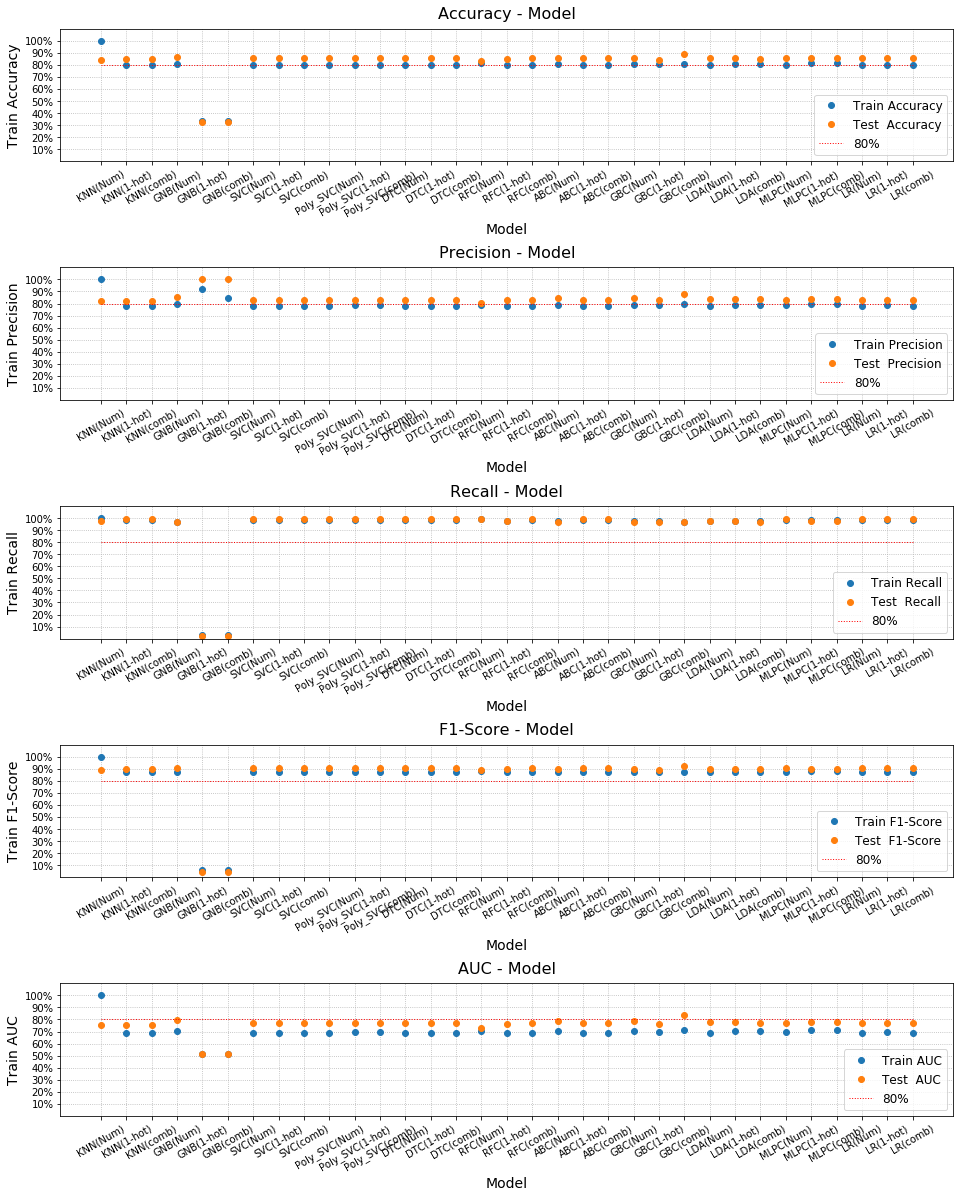

In [86]:
fig, ax = plt.subplots(5, 1, figsize = (16, 20)) # create a new figure & set the figure size

ax[0].plot(df_all_models_performance.columns, df_all_models_performance.loc["Train Accuracy",:], 'o') 
ax[0].plot(df_all_models_performance.columns, df_all_models_performance.loc["Test Accuracy",:],  'o') 
ax[0].plot(df_all_models_performance.columns, 0.8 * np.ones(33), linewidth = 1, color = 'red', linestyle = ':') 
ax[0].set_xlabel("Model",           fontsize = 14) 
ax[0].set_ylabel("Train Accuracy",  fontsize = 14) 
ax[0].set_ylim([0,1.1])
ax[0].set_yticks([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])
ax[0].set_yticklabels(['{:,.0%}'.format(x) for x in ax[0].get_yticks()])
ax[0].set_title("Accuracy - Model", fontsize = 16, pad = 10) # pad: offset of the title from the top of the axes 
ax[0].xaxis.grid(linestyle = ":") 
ax[0].yaxis.grid(which = "both", linestyle = ":") 
ax[0].legend(("Train Accuracy", "Test  Accuracy", "80%"), loc = 4, fontsize = 'large')
plt.sca(ax[0])
plt.xticks(df_all_models_performance.columns, df_all_models_performance.columns, rotation = 30)

ax[1].plot(df_all_models_performance.columns, df_all_models_performance.loc["Train Precision",:], 'o') 
ax[1].plot(df_all_models_performance.columns, df_all_models_performance.loc["Test Precision",:],  'o') 
ax[1].plot(df_all_models_performance.columns, 0.8 * np.ones(33), linewidth = 1, color = 'red', linestyle = ':') 
ax[1].set_xlabel("Model",           fontsize = 14) 
ax[1].set_ylabel("Train Precision",  fontsize = 14) 
ax[1].set_ylim([0,1.1])
ax[1].set_yticks([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])
ax[1].set_yticklabels(['{:,.0%}'.format(x) for x in ax[0].get_yticks()])
ax[1].set_title("Precision - Model", fontsize = 16, pad = 10) # pad: offset of the title from the top of the axes 
ax[1].xaxis.grid(linestyle = ":") 
ax[1].yaxis.grid(which = "both", linestyle = ":") 
ax[1].legend(("Train Precision", "Test  Precision", "80%"), loc = 4, fontsize = 'large')
plt.sca(ax[1])
plt.xticks(df_all_models_performance.columns, df_all_models_performance.columns, rotation = 30)

ax[2].plot(df_all_models_performance.columns, df_all_models_performance.loc["Train Recall",:], 'o') 
ax[2].plot(df_all_models_performance.columns, df_all_models_performance.loc["Test Recall",:],  'o') 
ax[2].plot(df_all_models_performance.columns, 0.8 * np.ones(33), linewidth = 1, color = 'red', linestyle = ':') 
ax[2].set_xlabel("Model",           fontsize = 14) 
ax[2].set_ylabel("Train Recall",  fontsize = 14) 
ax[2].set_ylim([0,1.1])
ax[2].set_yticks([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])
ax[2].set_yticklabels(['{:,.0%}'.format(x) for x in ax[0].get_yticks()])
ax[2].set_title("Recall - Model", fontsize = 16, pad = 10) # pad: offset of the title from the top of the axes 
ax[2].xaxis.grid(linestyle = ":") 
ax[2].yaxis.grid(which = "both", linestyle = ":") 
ax[2].legend(("Train Recall", "Test  Recall", "80%"), loc = 4, fontsize = 'large')
plt.sca(ax[2])
plt.xticks(df_all_models_performance.columns, df_all_models_performance.columns, rotation = 30)

ax[3].plot(df_all_models_performance.columns, df_all_models_performance.loc["Train F1_Score",:], 'o') 
ax[3].plot(df_all_models_performance.columns, df_all_models_performance.loc["Test F1_Score",:],  'o') 
ax[3].plot(df_all_models_performance.columns, 0.8 * np.ones(33), linewidth = 1, color = 'red', linestyle = ':') 
ax[3].set_xlabel("Model",           fontsize = 14) 
ax[3].set_ylabel("Train F1-Score",  fontsize = 14) 
ax[3].set_ylim([0,1.1])
ax[3].set_yticks([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])
ax[3].set_yticklabels(['{:,.0%}'.format(x) for x in ax[0].get_yticks()])
ax[3].set_title("F1-Score - Model", fontsize = 16, pad = 10) # pad: offset of the title from the top of the axes 
ax[3].xaxis.grid(linestyle = ":") 
ax[3].yaxis.grid(which = "both", linestyle = ":") 
ax[3].legend(("Train F1-Score", "Test  F1-Score", "80%"), loc = 4, fontsize = 'large')
plt.sca(ax[3])
plt.xticks(df_all_models_performance.columns, df_all_models_performance.columns, rotation = 30)

ax[4].plot(df_all_models_performance.columns, df_all_models_performance.loc["Train AUC",:], 'o') 
ax[4].plot(df_all_models_performance.columns, df_all_models_performance.loc["Test AUC",:],  'o') 
ax[4].plot(df_all_models_performance.columns, 0.8 * np.ones(33), linewidth = 1, color = 'red', linestyle = ':') 
ax[4].set_xlabel("Model",           fontsize = 14) 
ax[4].set_ylabel("Train AUC",  fontsize = 14) 
ax[4].set_ylim([0,1.1])
ax[4].set_yticks([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])
ax[4].set_yticklabels(['{:,.0%}'.format(x) for x in ax[0].get_yticks()])
ax[4].set_title("AUC - Model", fontsize = 16, pad = 10) # pad: offset of the title from the top of the axes 
ax[4].xaxis.grid(linestyle = ":") 
ax[4].yaxis.grid(which = "both", linestyle = ":") 
ax[4].legend(("Train AUC", "Test  AUC", "80%"), loc = 4, fontsize = 'large')
plt.sca(ax[4])
plt.xticks(df_all_models_performance.columns, df_all_models_performance.columns, rotation = 30)


plt.subplots_adjust(hspace = 0.8) # adjust the space between the 2 subplots
plt.show()


# 5. Ensemble Learning

### 5.1 Voting

Voting for the 3 preprocessing methods are tested. Top 3 performance models are selected for voting. Sometimes, it shows better result (better than all the 3), sometimes it doesn't. This is probably because the results for some instances are different from the highest test accuracy (AUC) model and the other two.

In [87]:
voting_num_classifier = VotingClassifier(estimators = [#("KNN",      KNN_model_num), 
                                                       ("GNB",      GNB_model_num),
                                                       #("SCV",      SVC_model_num),
                                                       #("Poly_SVC", Poly_SVC_model_num),
                                                       #("DTC",      DTC_model_num),
                                                       #("RFC",      RFC_model_num),
                                                       ("ABC",      ABC_model_num),
                                                       #("GBC",      GBC_model_num),
                                                       #("LDA",      LDA_model_num),
                                                       ("MLPC",     MLPC_model_num),
                                                       #("LR",       LR_model_num)
                                                       ], voting='soft')
voting_num_classifier.fit(X_train_num_scaled, y_train_num)

print("Accuracy:")
for clf in (GNB_model_num, ABC_model_num, MLPC_model_num, voting_num_classifier):
    clf.fit(X_train_num_scaled, y_train_num)
    y_test_pred = clf.predict(X_test_num_scaled)
    print('{:<20}  {:<30}'.format(clf.__class__.__name__,accuracy_score(y_test_num, y_test_pred)))
print()
print("ROC_AUC:")
for clf in (GNB_model_num, ABC_model_num, MLPC_model_num, voting_num_classifier):
    clf.fit(X_train_num_scaled, y_train_num)
    y_test_pred = clf.predict(X_test_num_scaled)
    print('{:<20}  {:<30}'.format(clf.__class__.__name__,roc_auc_score(y_test_num, y_test_pred)))

Accuracy:
GaussianNB            0.8617886178861789            
AdaBoostClassifier    0.8536585365853658            
MLPClassifier         0.8617886178861789            
VotingClassifier      0.8536585365853658            

ROC_AUC:
GaussianNB            0.798142414860681             
AdaBoostClassifier    0.784984520123839             
MLPClassifier         0.7835913312693499            
VotingClassifier      0.796749226006192             


In [88]:
voting_1hot_classifier = VotingClassifier(estimators = [#("KNN",      KNN_model_1hot, 
                                                       #("GNB",      GNB_model_1hot),
                                                       #("SCV",      SVC_model_1hot),
                                                       ("Poly_SVC", Poly_SVC_model_1hot),
                                                       #("DTC",      DTC_model_1hot),
                                                       #("RFC",      RFC_model_1hot),
                                                       #("ABC",      ABC_model_1hot),
                                                       #("GBC",      GBC_model_1hot),
                                                       ("LDA",      LDA_model_1hot),
                                                       ("MLPC",     MLPC_model_1hot),
                                                       #("LR",       LR_model_1hot)
                                                       ], voting='hard')
voting_1hot_classifier.fit(X_train_1hot_scaled, y_train_1hot)

print("Accuracy:")
for clf in (Poly_SVC_model_1hot, LDA_model_1hot, MLPC_model_1hot, voting_1hot_classifier):
    clf.fit(X_train_1hot_scaled, y_train_1hot)
    y_test_pred = clf.predict(X_test_1hot_scaled)
    print('{:<30}  {:<20}'.format(clf.__class__.__name__,accuracy_score(y_test_1hot, y_test_pred)))
print()
print("ROC_AUC:")
for clf in (Poly_SVC_model_1hot, LDA_model_1hot, MLPC_model_1hot, voting_1hot_classifier):
    clf.fit(X_train_1hot_scaled, y_train_1hot)
    y_test_pred = clf.predict(X_test_1hot_scaled)
    print('{:<30}  {:<20}'.format(clf.__class__.__name__,roc_auc_score(y_test_1hot, y_test_pred)))

Accuracy:
SVC                             0.8536585365853658  
LinearDiscriminantAnalysis      0.8536585365853658  
MLPClassifier                   0.8617886178861789  
VotingClassifier                0.8455284552845529  

ROC_AUC:
SVC                             0.7704334365325077  
LinearDiscriminantAnalysis      0.7777089783281734  
MLPClassifier                   0.7645510835913313  
VotingClassifier                0.7777089783281734  


In [89]:
voting_num_1hot_classifier = VotingClassifier(estimators = [#("KNN",      KNN_model_num_1hot, 
                                                            #("GNB",      GNB_model_num_1hot),
                                                            #("SCV",      SVC_model_num_1hot),
                                                             ("Poly_SVC", Poly_SVC_model_num_1hot),
                                                             ("DTC",      DTC_model_num_1hot),
                                                            #("RFC",      RFC_model_num_1hot),
                                                            #("ABC",      ABC_model_num_1hot),
                                                             ("GBC",      GBC_model_num_1hot),
                                                            #("LDA",      LDA_model_num_1hot),
                                                            #("MLPC",     MLPC_model_num_1hot),
                                                            #("LR",       LR_model_num_1hot)
                                                            ], voting='hard')
voting_num_1hot_classifier.fit(X_train_num_1hot_scaled, y_train_num_1hot)

print("Accuracy:")
for clf in (Poly_SVC_model_num_1hot, DTC_model_num_1hot, GBC_model_num_1hot, voting_num_1hot_classifier):
    clf.fit(X_train_num_1hot_scaled, y_train_num_1hot)
    y_test_pred = clf.predict(X_test_num_1hot_scaled)
    print('{:<30}  {:<20}'.format(clf.__class__.__name__,accuracy_score(y_test_num_1hot, y_test_pred)))
print()
print("ROC_AUC:")
for clf in (Poly_SVC_model_num_1hot, DTC_model_num_1hot, GBC_model_num_1hot, voting_num_1hot_classifier):
    clf.fit(X_train_num_1hot_scaled, y_train_num_1hot)
    y_test_pred = clf.predict(X_test_num_1hot_scaled)
    print('{:<30}  {:<20}'.format(clf.__class__.__name__,roc_auc_score(y_test_num_1hot, y_test_pred)))

Accuracy:
SVC                             0.8536585365853658  
DecisionTreeClassifier          0.8455284552845529  
GradientBoostingClassifier      0.8861788617886179  
VotingClassifier                0.8536585365853658  

ROC_AUC:
SVC                             0.7704334365325077  
DecisionTreeClassifier          0.7704334365325077  
GradientBoostingClassifier      0.8376160990712075  
VotingClassifier                0.7704334365325077  


### 5.2 Bagging

GNB(Num) model is selected for bagging due to its highest performance in both Accuracy and AUC on test set.  
Pasting and Bagging are compared by grid search, drawing samples with replacement gives better result.  
Random Patches and Random Subspaces are also tested.

In [90]:
bag_clf = BaggingClassifier(GNB_model_num,
                            n_estimators=500, max_samples=100, bootstrap=True,
                            n_jobs=-1, random_state=42)
bag_clf.fit(X_train_num_scaled, y_train_num)
y_pred_num = bag_clf.predict(X_test_num_scaled)
print(accuracy_score(y_test_num, y_pred_num))
print(roc_auc_score(y_test_num, y_pred_num))

0.8617886178861789
0.7835913312693499


In [91]:
parameters_range = {'base_estimator':     [GNB_model_num],
                    'n_estimators':       [1, 5, 10, 20, 30, 40, 50, 60, 70, 100, 500],
                    'bootstrap':          [True, False],
                    'bootstrap_features': [True, False],
                    'max_samples':        [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
                    'max_features':       [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
                   }
grid = GridSearchCV(BaggingClassifier(), 
                    parameters_range, 
                    cv      = 5,
                    scoring = 'f1',
                    n_jobs  = -1)
grid.fit(X_train_num_scaled, y_train_num)
print_best_params_score(grid)
y_train_pred   = grid.best_estimator_.predict(X_train_num_scaled)
y_test_pred    = grid.best_estimator_.predict(X_test_num_scaled)
print()
print(accuracy_score(y_test_num, y_test_pred))
print(roc_auc_score(y_test_num, y_test_pred))

Best Parameters:
{'base_estimator': GaussianNB(priors=None, var_smoothing=1e-09), 'bootstrap': True, 'bootstrap_features': False, 'max_features': 0.6, 'max_samples': 1.0, 'n_estimators': 5}
Best F1 Score:
0.8761366482160259

0.8699186991869918
0.8040247678018575


# 6. Conclusion

Home loans training and test data sets were given in this project.    

Apart from the attribute to be predicted (Loan Status), 5 numerical and 7 object attributes were found initially. After EDA, there are only 3 real numerical attributes (Applicant Income, Co-applicant Income and Loan Amount); all the others (including the attribute to be predicted) can be considered as categorical attributes.   

In the initial correlation check between Loan Status and all the other attributes, Credit History is found most related to the loan approval result in both training set and test set (both >0.5).   

In data preparation part, the instances with missing data was initially dropped (about 1/5 of the original data set). But, considering this is relatively small data set, and too many missing data. The missing values are filled, either by mode (categorical) or average(numerical). And 1 instance is removed due to much out-of-range of its Applicant Income. It may affect some models which are sensitive to outliers.   

Several new features are generated and added to the data set, which are not found contribute too much to the prediction for each one of them. However, they help to improve the models performance when working together.   

In total, there are 3 data pre-processing methods are used:   
1)	Numerical: 17 attributes   
2)	1-hot encoding: 30 attributes   
3)	Numerical + 1-hot encoding:  40 attributes   

Then, 3 pipelines were built for each of the data sets after 3 methods of data pre-processing.    
3 quick models (logistic regression, SVC and decision tree) were built and tested for analysing important features and types of errors.    

10 models are fine-tuned and compared. They are KNN, Gaussian Naïve Bayes, SVC, Decision Tree Classifier, Random Forest Classifier, Ada Boost Classifier, Gradient Boosting Classifier, Linear Discriminant Analysis, MLPClassifier, Logistic Regression. Also, in this project, f1 score is chosen for tuning the model; ROC AUC is used to do comparison among models (the reason was discussed in section 4.2).   

Gradient Boosting(Num + 1-hot), Gaussian Naïve Bayes (Num), Ada Boosting (Num) and Gradient Boosting(Num) achieves the highest AUC score.   

Gradient Boosting(Num + 1-hot) achieves 88.6% accuracy and 83.8% AUC.   

Voting for the 3 pre-processing methods are tested. Top 3 performance models are selected for voting. Sometimes, it shows better result (better than all the 3), sometimes it doesn't. This is probably because the results for certain instances in the other two models are different from the highest test accuracy (AUC) model.   

GNB(Num) model is selected for bagging due to its highest performance in both Accuracy and AUC on test set. Pasting and Bagging are compared by grid search, drawing samples with replacement gives better result. Random Patches and Random Subspaces are also tested.   

Underfitting problem is in almost all the models developed in this project. Several methods, like increasing regularisation, adding pre-pruning process, etc. are tried to minimise it, but most of the time they do not work very well. The problem may be solved by collecting more data.   